In [1]:
# Import Python Packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import spearmanr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats.mstats import winsorize
from scipy.stats import chi2
import statsmodels.api as sm
from scipy.stats import kstest
from scipy.stats import wilcoxon
import statsmodels.formula.api as smf
from scipy.stats import levene
import statsmodels.api as sm

In [2]:
#Load in that SWEET SWEET Дата
os.chdir('/Users/jackcrosby/Desktop/tACS_Pilot_Study')
df = pd.read_spss('tACS_Reanalysis_20220208_noSevereBAI.sav')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
display(df)

,Participant,ParticipantNumber,Age,Gender,BDIBaselineCat,BAIBaselineCat,MeanAlphaF3D1,MeanAlphaF4D1,MeanAlphaF3D3,MeanAlphaF4D3,Day1F3Hz,Day1F3Power,Day1F4Hz,Day1F4Power,Day3F3Hz,Day3F3Power,Day3F4Hz,Day3F4Power,Day1PeakAsym,Day3PeakAsym,Day1PreBDI,Day1PreBAI,Day1PreSAS,Day1PrePANAS_P,Day1PrePANAS_N,Day1PostBDI,Day1PostBAI,Day1PostSAS,Day1PostPANAS_P,Day1PostPANAS_N,Day2PreBDI,Day2PreBAI,Day2PreSAS,Day2PrePANAS_P,Day2PrePANAS_N,Day2PostBDI,Day2PostBAI,Day2PostSAS,Day2PostPANAS_P,Day2PostPANAS_N,Day3PreBDI,Day3PreBAI,Day3PreSAS,Day3PrePANAS_P,Day3PrePANAS_N,Day3PostBDI,Day3PostBAI,Day3PostSAS,Day3PostPANAS_P,Day3PostPANAS_N,DiffPeakAsymD3_D1,MagPeakAsymDiff,DiffBDI_PreD1_PostD3,DiffBAI_PreD1_PostD3,DiffSAS_PreD1_PostD3,DiffPANAS_P_PreD1_PostD3,DiffPANAS_N_PreD1_PostD3,filter_$,Day1PeakDiff,Day3PeakDiff,Day3minus1PeakDiff
0,1974,1.0,38.0,Male,Minimal,Minimal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,3.0,28.0,20.0,22.0,8.0,9.0,31.0,37.0,19.0,9.0,3.0,28.0,22.0,14.0,8.0,0.0,28.0,23.0,12.0,9.0,3.0,28.0,25.0,15.0,6.0,3.0,27.0,27.0,15.0,NaN,NaN,3.0,0.0,1.0,-7.0,7.0,Selected,NaN,NaN,NaN
1,EF05,2.0,48.0,Female,Minimal,Minimal,6.438700,6.994830,4.704234,8.175600,10.0,12.750,10.0,12.86000,10.0,10.7600,10.0,13.1900,0.253284,5.595282,7.0,6.0,31.0,38.0,16.0,6.0,0.0,26.0,40.0,12.0,6.0,6.0,28.0,43.0,13.0,6.0,0.0,27.0,37.0,10.0,5.0,4.0,25.0,35.0,13.0,2.0,0.0,22.0,43.0,10.0,5.341997,5.341997,5.0,6.0,9.0,-5.0,6.0,Selected,0.11000,2.430,2.32000
2,C3T21,3.0,23.0,Female,Minimal,Minimal,6.559012,4.454422,2.899865,4.762680,10.0,7.896,9.0,6.53000,9.0,4.1480,9.0,6.2960,-3.154542,4.950558,11.0,5.0,35.0,39.0,20.0,10.0,4.0,33.0,36.0,19.0,8.0,3.0,31.0,37.0,18.0,7.0,2.0,28.0,36.0,13.0,6.0,1.0,30.0,39.0,15.0,5.0,0.0,28.0,39.0,15.0,8.105100,8.105100,6.0,5.0,7.0,0.0,5.0,Selected,-1.36600,2.148,3.51400
3,721,4.0,24.0,Male,Minimal,Moderate,-7.529995,-10.781873,-0.749378,-1.400708,11.0,-1.702,10.0,-6.46200,11.0,5.2790,11.0,4.2680,-10.960305,-2.325611,12.0,18.0,38.0,33.0,24.0,5.0,7.0,31.0,26.0,14.0,8.0,8.0,35.0,29.0,15.0,5.0,5.0,31.0,29.0,12.0,7.0,4.0,28.0,34.0,14.0,4.0,4.0,28.0,29.0,13.0,8.634694,8.634694,8.0,14.0,10.0,4.0,11.0,Selected,-4.76000,-1.011,3.74900
4,3004,6.0,51.0,Male,Minimal,Mild,5.791324,5.656198,4.836679,5.050957,8.0,9.439,7.0,10.46000,6.0,11.5200,6.0,9.6220,2.348637,-4.374912,8.0,12.0,33.0,29.0,17.0,6.0,10.0,35.0,43.0,20.0,4.0,8.0,29.0,23.0,12.0,5.0,3.0,33.0,26.0,15.0,5.0,9.0,33.0,24.0,13.0,7.0,8.0,32.0,21.0,18.0,-6.723548,6.723548,1.0,4.0,1.0,8.0,-1.0,Selected,1.02100,-1.898,-2.91900
5,0214,7.0,24.0,Female,Minimal,Moderate,2.479348,3.401835,1.533312,1.296303,11.0,4.082,11.0,5.64800,10.0,3.6820,10.0,4.3030,3.615059,1.427603,13.0,22.0,30.0,40.0,21.0,0.0,3.0,26.0,48.0,14.0,8.0,8.0,32.0,38.0,13.0,0.0,3.0,21.0,44.0,10.0,2.0,5.0,23.0,41.0,11.0,0.0,1.0,22.0,43.0,10.0,-2.187456,2.187456,13.0,21.0,8.0,-3.0,11.0,Selected,1.56600,0.621,-0.94500
6,1906,9.0,33.0,Female,Moderate,Moderate,-0.465740,-0.622096,-0.552903,-0.625520,7.0,0.569,11.0,0.04388,12.0,0.7965,11.0,0.2525,-1.220370,-1.266422,23.0,23.0,34.0,26.0,31.0,9.0,20.0,38.0,27.0,18.0,10.0,8.0,32.0,27.0,13.0,7.0,1.0,26.0,26.0,11.0,16.0,6.0,20.0,16.0,20.0,2.0,2.0,30.0,31.0,15.0,-0.046052,0.046052,21.0,21.0,4.0,-5.0,16.0,Selected,-0.52512,-0.544,-0.01888
7,280699,11.0,20.0,Female,Moderate,Moderate,1.416173,-3.005396,-0.378097,-1.884182,10.0,2.058,10.0,-2.15600,8.0,1.6280,10.0,-1.1160,-9.716909,-6.332109,28.0,23.0,44.0,16.0,37.0,6.0,0.0,24.0,15.0,10.0,34.0,21.0,46.0,12.0,23.0,8.0,4.0,29.0,12.0,18.0,16.0,11.0,33.0,17.0,15.0,10.0,11.0,33.0,11.0,13.0,3.384800,3.384800,18.0,12.0,11.0,5.0,24.0,Selected,-4.21400,-2.744,1.47000
8,24601,12.0,25.0,Male,Moderate,Moderate,-0.808025,-0.574616,0.236179,0.160792,10.0,1.996,10.0,1.43100,11.0,3.2060,11.0,3.3060,-1.312474,0.230259,23.0,21.0,41.0,22.0,28.0,16.0,1.0,35.0,27.0,14.0,16.0,9.0,41.0,24.0,15.0,16.0,1.0,38.0,25.0,10.0,23.0,13.0,42.0,25.0,16.0,12.0,1.0,31.0,30.0,15.0,1.542732,1.542732,11.0,20.0,10.0,-8.0,13.0,Selected,-0.56500,0.100,0.66500


Missing Data Analysis 
Visual inspection shows N=8, only one participant is sowing NaNs. Column wise, this means that there is 12.5%
Missing data - This means that data imputation would not be feasible. 

HOWEVER, a recent paper by Madley-Dowd et al. (2019) showed MI is still valid up to 90% missing data so MI will be used to impute the missing FAA values. 

In [3]:
# Extract relevant Дата for graphs
df2 = df[['Day1PeakAsym','Day3PeakAsym','Day1PreSAS','Day3PostSAS','Day1PreBAI','Day3PostBAI','Day1PreBDI',
          'Day3PostBDI','Day1PrePANAS_P','Day3PostPANAS_P','Day1PrePANAS_N','Day3PostPANAS_N']]
display(df2)

,Day1PeakAsym,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N
0,NaN,NaN,28.0,27.0,3.0,3.0,9.0,6.0,20.0,27.0,22.0,15.0
1,0.253284,5.595282,31.0,22.0,6.0,0.0,7.0,2.0,38.0,43.0,16.0,10.0
2,-3.154542,4.950558,35.0,28.0,5.0,0.0,11.0,5.0,39.0,39.0,20.0,15.0
3,-10.960305,-2.325611,38.0,28.0,18.0,4.0,12.0,4.0,33.0,29.0,24.0,13.0
4,2.348637,-4.374912,33.0,32.0,12.0,8.0,8.0,7.0,29.0,21.0,17.0,18.0
5,3.615059,1.427603,30.0,22.0,22.0,1.0,13.0,0.0,40.0,43.0,21.0,10.0
6,-1.220370,-1.266422,34.0,30.0,23.0,2.0,23.0,2.0,26.0,31.0,31.0,15.0
7,-9.716909,-6.332109,44.0,33.0,23.0,11.0,28.0,10.0,16.0,11.0,37.0,13.0
8,-1.312474,0.230259,41.0,31.0,21.0,1.0,23.0,12.0,22.0,30.0,28.0,15.0


In [4]:
#Multiple Imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df2)
IterativeImputer(random_state=0)
X_test = df2
# the model learns that the second feature is double the first
display(imp.transform(X_test))

array([[ -2.32307146,   1.48410189,  28.        ,  27.        ,
          3.        ,   3.        ,   9.        ,   6.        ,
         20.        ,  27.        ,  22.        ,  15.        ],
       [  0.25328436,   5.59528178,  31.        ,  22.        ,
          6.        ,   0.        ,   7.        ,   2.        ,
         38.        ,  43.        ,  16.        ,  10.        ],
       [ -3.15454158,   4.95055795,  35.        ,  28.        ,
          5.        ,   0.        ,  11.        ,   5.        ,
         39.        ,  39.        ,  20.        ,  15.        ],
       [-10.96030504,  -2.32561094,  38.        ,  28.        ,
         18.        ,   4.        ,  12.        ,   4.        ,
         33.        ,  29.        ,  24.        ,  13.        ],
       [  2.34863679,  -4.37491168,  33.        ,  32.        ,
         12.        ,   8.        ,   8.        ,   7.        ,
         29.        ,  21.        ,  17.        ,  18.        ],
       [  3.6150586 ,   1.42760276,

Multiple imputation has provided the first Day1PeakAsym as -2.323071 and the Day3PeakAsym as 1.484101. 

The df.replace() function wasn't working so I manually imported it into the dataset

In [5]:
df3 = pd.read_csv('tACS_Reanalysis_20220208_noSevereBAI.csv')
df3 = df3[['Day1PeakAsym','Day3PeakAsym','Day1PreSAS','Day3PostSAS','Day1PreBAI','Day3PostBAI','Day1PreBDI',
          'Day3PostBDI','Day1PrePANAS_P','Day3PostPANAS_P','Day1PrePANAS_N','Day3PostPANAS_N']]
display(df3)

,Day1PeakAsym,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N
0,-2.32,1.48,28,27,3,3,9,6,20,27,22,15
1,0.25,5.60,31,22,6,0,7,2,38,43,16,10
2,-3.15,4.95,35,28,5,0,11,5,39,39,20,15
3,-10.96,-2.33,38,28,18,4,12,4,33,29,24,13
4,2.35,-4.37,33,32,12,8,8,7,29,21,17,18
5,3.62,1.43,30,22,22,1,13,0,40,43,21,10
6,-1.22,-1.27,34,30,23,2,23,2,26,31,31,15
7,-9.72,-6.33,44,33,23,11,28,10,16,11,37,13
8,-1.31,0.23,41,31,21,1,23,12,22,30,28,15


Now that multiple imputation has been completed. We can move on to the assessment of the following:
Outliers (Univariate and multivariate)
Normality
This will dictate the type of correlation that will be used - because the sample size is small it'll likely that spearman's will be used anyway. 

<AxesSubplot:>

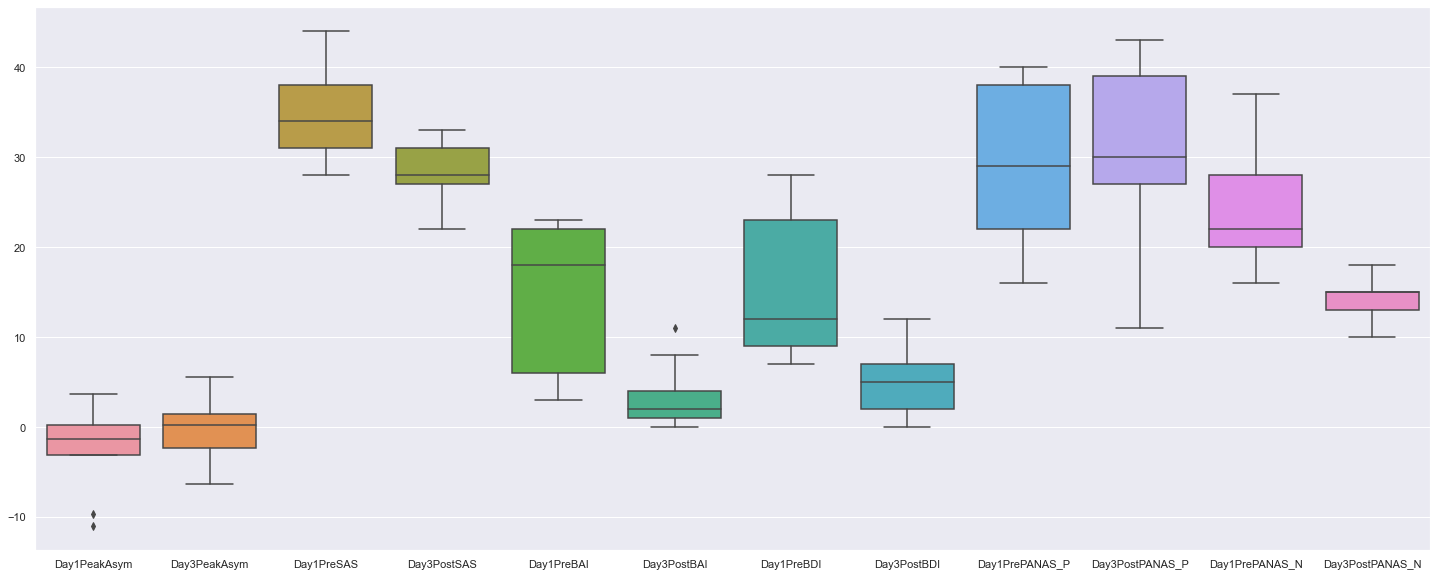

In [6]:
sns.set(rc={"figure.figsize":(25, 10)})
sns.boxplot(data = df3)

As can be seen here: There are 2 outliers in the Day1PeakAsym and an outlier in the Day3PostBDI. 
To mitigate these outliers, I prefer to winsorize the data. As the датасет is very small, it's better to winzorise than to remove outliers. Preserving data as much as possible. 

,Day1PeakAsym,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N,Day1PeakAsym_win
0,-2.32,1.48,28,27,3,3,9,6,20,27,22,15,-2.32
1,0.25,5.60,31,22,6,0,7,2,38,43,16,10,0.25
2,-3.15,4.95,35,28,5,0,11,5,39,39,20,15,-3.15
3,-10.96,-2.33,38,28,18,4,12,4,33,29,24,13,-3.15
4,2.35,-4.37,33,32,12,8,8,7,29,21,17,18,2.35
5,3.62,1.43,30,22,22,1,13,0,40,43,21,10,3.62
6,-1.22,-1.27,34,30,23,2,23,2,26,31,31,15,-1.22
7,-9.72,-6.33,44,33,23,11,28,10,16,11,37,13,-3.15
8,-1.31,0.23,41,31,21,1,23,12,22,30,28,15,-1.31


<AxesSubplot:>

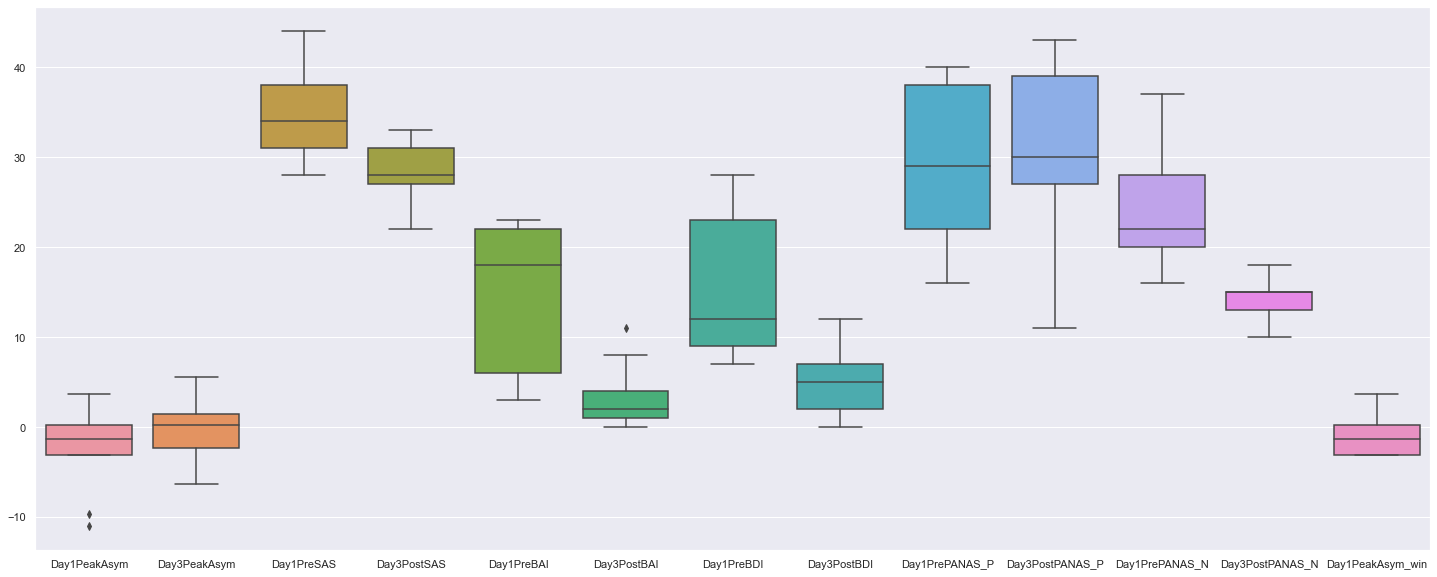

In [7]:
#Create variable with Day1PeakAsym winsorized. 
df3['Day1PeakAsym_win'] = winsorize(df3['Day1PeakAsym'], (0.3, 0.1))
display(df3)
sns.boxplot(data = df3)

,Day1PeakAsym,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N,Day1PeakAsym_win,Day3PostBAI_win
0,-2.32,1.48,28,27,3,3,9,6,20,27,22,15,-2.32,3
1,0.25,5.60,31,22,6,0,7,2,38,43,16,10,0.25,0
2,-3.15,4.95,35,28,5,0,11,5,39,39,20,15,-3.15,0
3,-10.96,-2.33,38,28,18,4,12,4,33,29,24,13,-3.15,4
4,2.35,-4.37,33,32,12,8,8,7,29,21,17,18,2.35,8
5,3.62,1.43,30,22,22,1,13,0,40,43,21,10,3.62,1
6,-1.22,-1.27,34,30,23,2,23,2,26,31,31,15,-1.22,2
7,-9.72,-6.33,44,33,23,11,28,10,16,11,37,13,-3.15,8
8,-1.31,0.23,41,31,21,1,23,12,22,30,28,15,-1.31,1


<AxesSubplot:>

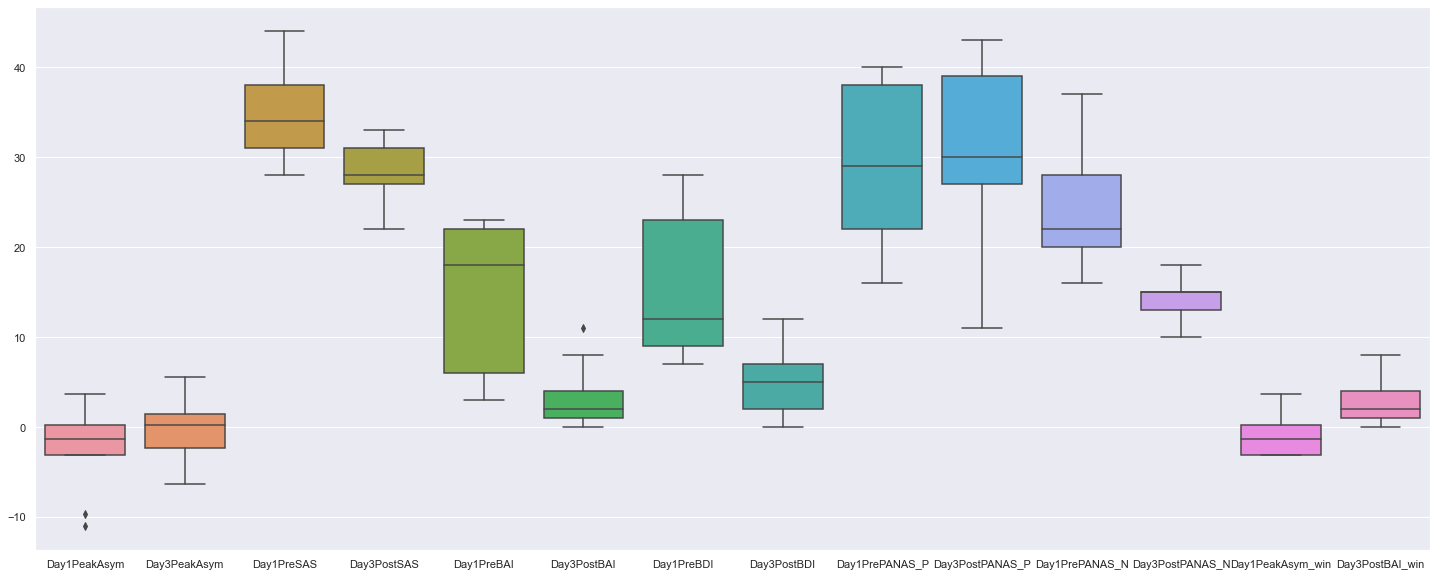

In [8]:
#Create variable with Day3PostBAI winsorized. 
df3['Day3PostBAI_win'] = winsorize(df3['Day3PostBAI'], (0.1, 0.2))
display(df3)
sns.boxplot(data = df3)

Remove the variables that are now redundant: These are the Day1PeakAsym & Day3PostBAI

In [9]:
df4 = df3[['Day1PeakAsym_win','Day3PeakAsym','Day1PreSAS','Day3PostSAS','Day1PreBAI','Day3PostBAI_win','Day1PreBDI',
          'Day3PostBDI','Day1PrePANAS_P','Day3PostPANAS_P','Day1PrePANAS_N','Day3PostPANAS_N']]
display(df4)

,Day1PeakAsym_win,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI_win,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N
0,-2.32,1.48,28,27,3,3,9,6,20,27,22,15
1,0.25,5.60,31,22,6,0,7,2,38,43,16,10
2,-3.15,4.95,35,28,5,0,11,5,39,39,20,15
3,-3.15,-2.33,38,28,18,4,12,4,33,29,24,13
4,2.35,-4.37,33,32,12,8,8,7,29,21,17,18
5,3.62,1.43,30,22,22,1,13,0,40,43,21,10
6,-1.22,-1.27,34,30,23,2,23,2,26,31,31,15
7,-3.15,-6.33,44,33,23,8,28,10,16,11,37,13
8,-1.31,0.23,41,31,21,1,23,12,22,30,28,15


Now we have this done, we can identify multivariate outliers using mahalanobis distance

In [10]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(df4)
    if not cov:
        cov = np.cov(df4.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [11]:
df4['mahalanobis'] = mahalanobis(x=df4, data=df4[['Day1PeakAsym_win', 'Day3PeakAsym', 'Day1PreSAS', 'Day3PostSAS', 
                                                 'Day3PostSAS', 'Day1PreBAI', 'Day3PostBAI_win', 'Day1PreBDI',
                                                'Day3PostBDI', 'Day1PrePANAS_P', 'Day3PostPANAS_P', 'Day1PrePANAS_N', 
                                                 'Day3PostPANAS_N']])
display(df4)

/var/folders/wr/9s_983rd7219064h8l10ycz40000gn/T/ipykernel_13038/2648501374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['mahalanobis'] = mahalanobis(x=df4, data=df4[['Day1PeakAsym_win', 'Day3PeakAsym', 'Day1PreSAS', 'Day3PostSAS',


,Day1PeakAsym_win,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI_win,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N,mahalanobis
0,-2.32,1.48,28,27,3,3,9,6,20,27,22,15,6.500182
1,0.25,5.60,31,22,6,0,7,2,38,43,16,10,6.383607
2,-3.15,4.95,35,28,5,0,11,5,39,39,20,15,4.559090
3,-3.15,-2.33,38,28,18,4,12,4,33,29,24,13,8.623962
4,2.35,-4.37,33,32,12,8,8,7,29,21,17,18,12.029562
5,3.62,1.43,30,22,22,1,13,0,40,43,21,10,10.080981
6,-1.22,-1.27,34,30,23,2,23,2,26,31,31,15,7.503647
7,-3.15,-6.33,44,33,23,8,28,10,16,11,37,13,6.902361
8,-1.31,0.23,41,31,21,1,23,12,22,30,28,15,6.277558


In [12]:
#Calculate Mahalanobis p value
df4['p'] = 1 - chi2.cdf(df4['mahalanobis'], 11)
display(df4)

,Day1PeakAsym_win,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI_win,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N,mahalanobis,p
0,-2.32,1.48,28,27,3,3,9,6,20,27,22,15,6.500182,0.837997
1,0.25,5.60,31,22,6,0,7,2,38,43,16,10,6.383607,0.846583
2,-3.15,4.95,35,28,5,0,11,5,39,39,20,15,4.559090,0.950629
3,-3.15,-2.33,38,28,18,4,12,4,33,29,24,13,8.623962,0.656558
4,2.35,-4.37,33,32,12,8,8,7,29,21,17,18,12.029562,0.361425
5,3.62,1.43,30,22,22,1,13,0,40,43,21,10,10.080981,0.523118
6,-1.22,-1.27,34,30,23,2,23,2,26,31,31,15,7.503647,0.756955
7,-3.15,-6.33,44,33,23,8,28,10,16,11,37,13,6.902361,0.806935
8,-1.31,0.23,41,31,21,1,23,12,22,30,28,15,6.277558,0.854218


Mahalanobis distance df is N-1. The p values show there are no multivariate outliers. The threshold is typically p <.001.

The next thing to assess is normality. The sample size is small so non-parametric testing will be used anyway, it's worth checking nonetheless. the boxplots also suggest most variables will be non-normal.

For normality. The Kolmogorov-Smirnov test was used because it is a nonparametric test and with small sample sizes like this, probably the better test. 

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=0.5554342292188321, pvalue=0.003859940234171426)

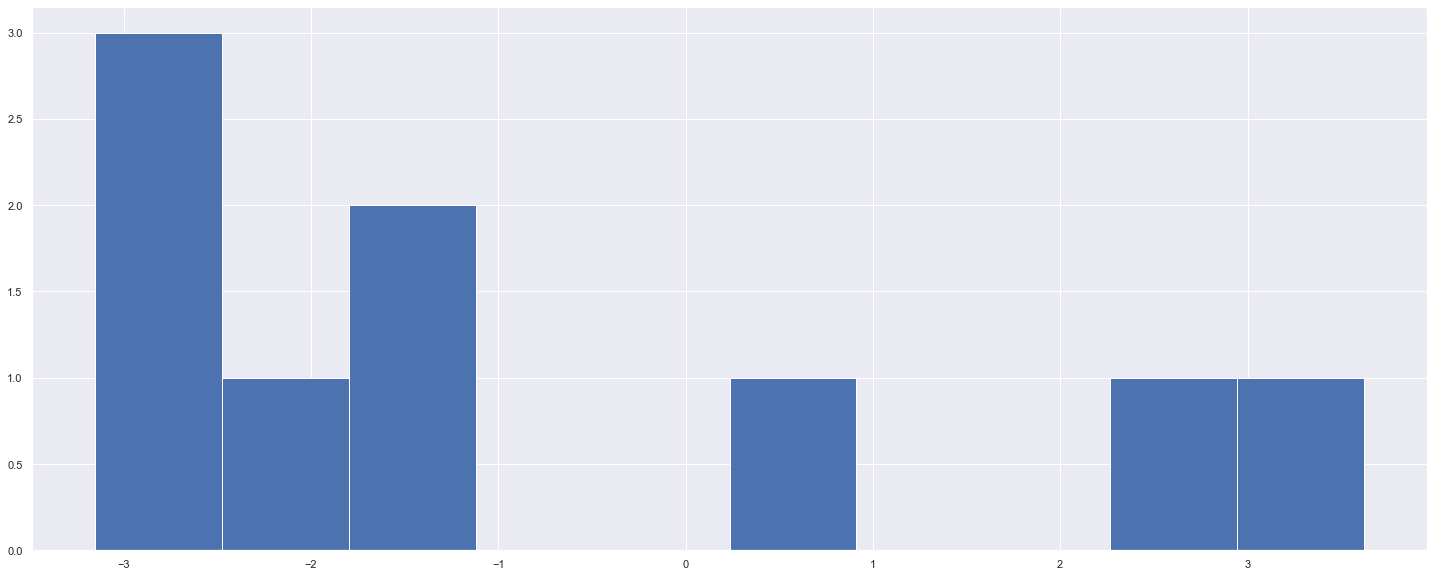

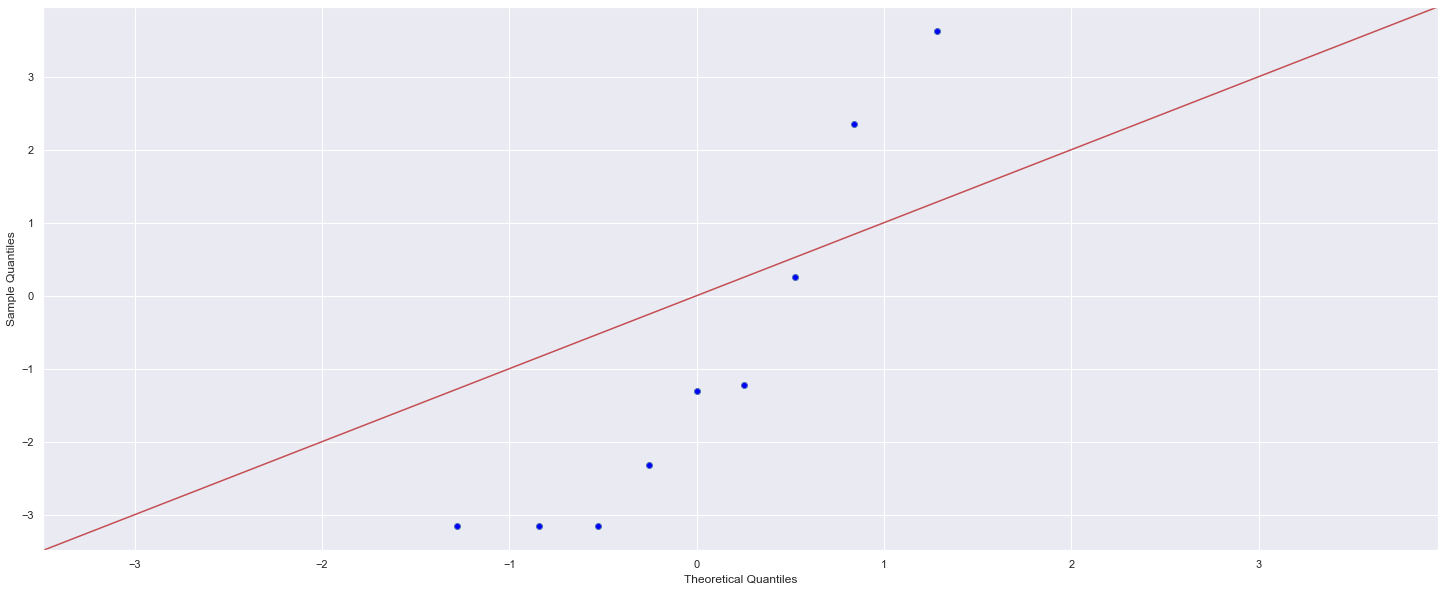

In [13]:
plt.hist(df4['Day1PeakAsym_win'])
sm.qqplot(df4['Day1PeakAsym_win'], line='45')
kstest(df4['Day1PeakAsym_win'], 'norm')

The graphs show large deviation from normality, further confirmed by the Kolmogorov-Smirnov test statistic. Shapiro-Wilk was run which suggested from the analysis that the data was normally distributed, thus also confirming the use of Kolmogorov-Smirnov over Shapiro-Wilk

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=0.36808593490770525, pvalue=0.133664436478943)

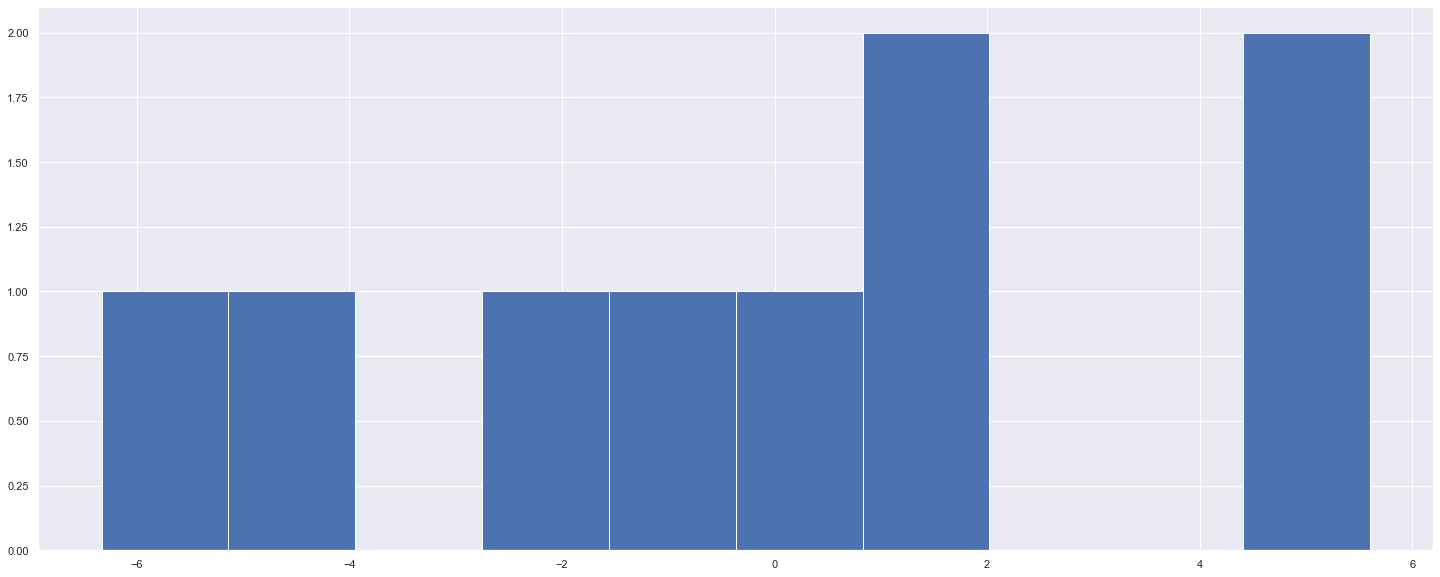

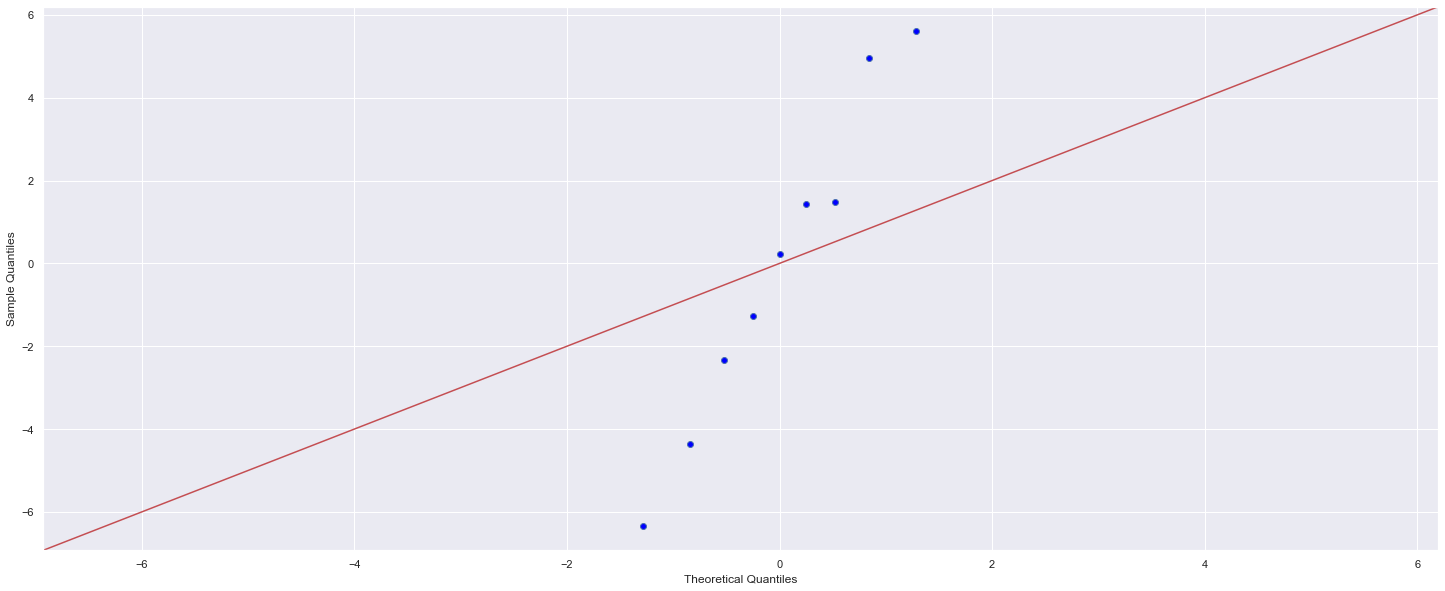

In [14]:
plt.hist(df4['Day3PeakAsym'])
sm.qqplot(df4['Day3PeakAsym'], line='45')
kstest(df4['Day3PeakAsym'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=1.0, pvalue=0.0)

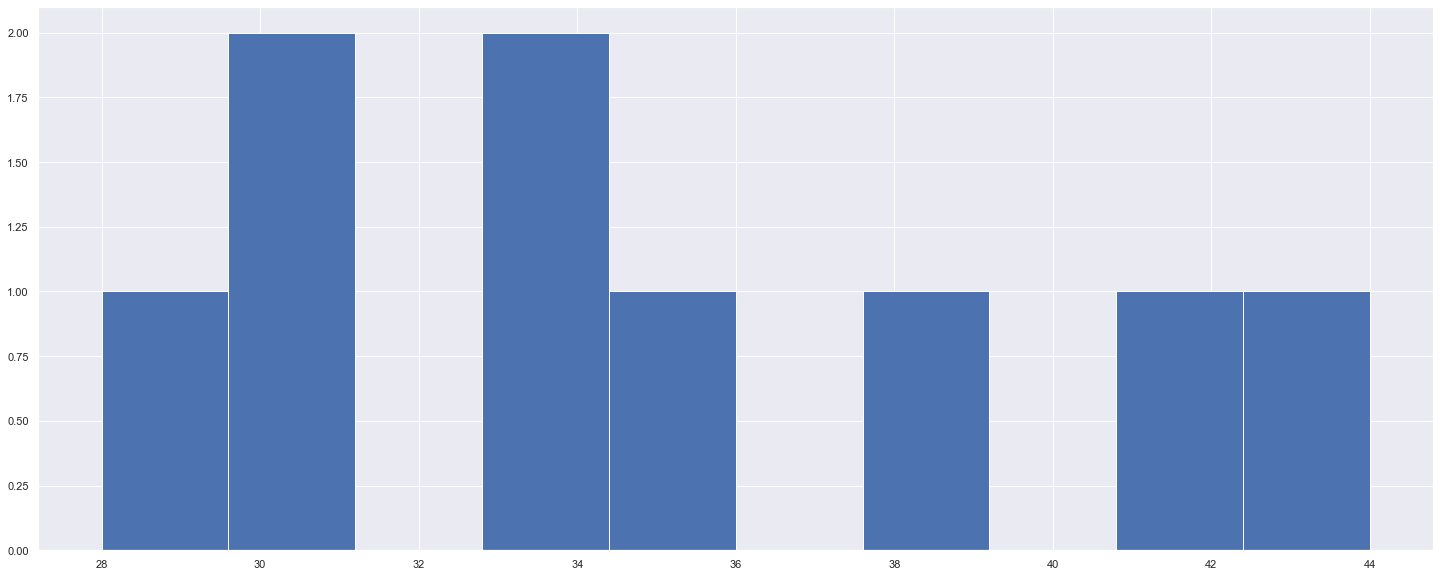

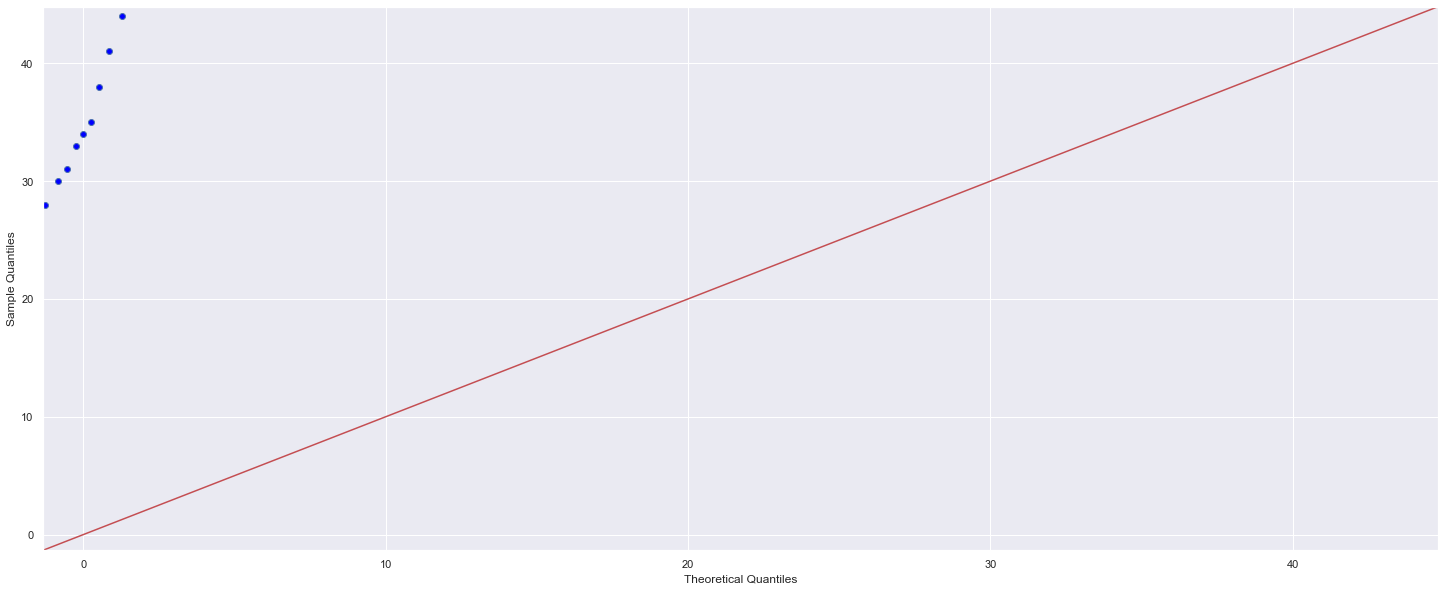

In [15]:
plt.hist(df4['Day1PreSAS'])
sm.qqplot(df4['Day1PreSAS'], line='45')
kstest(df4['Day1PreSAS'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=1.0, pvalue=0.0)

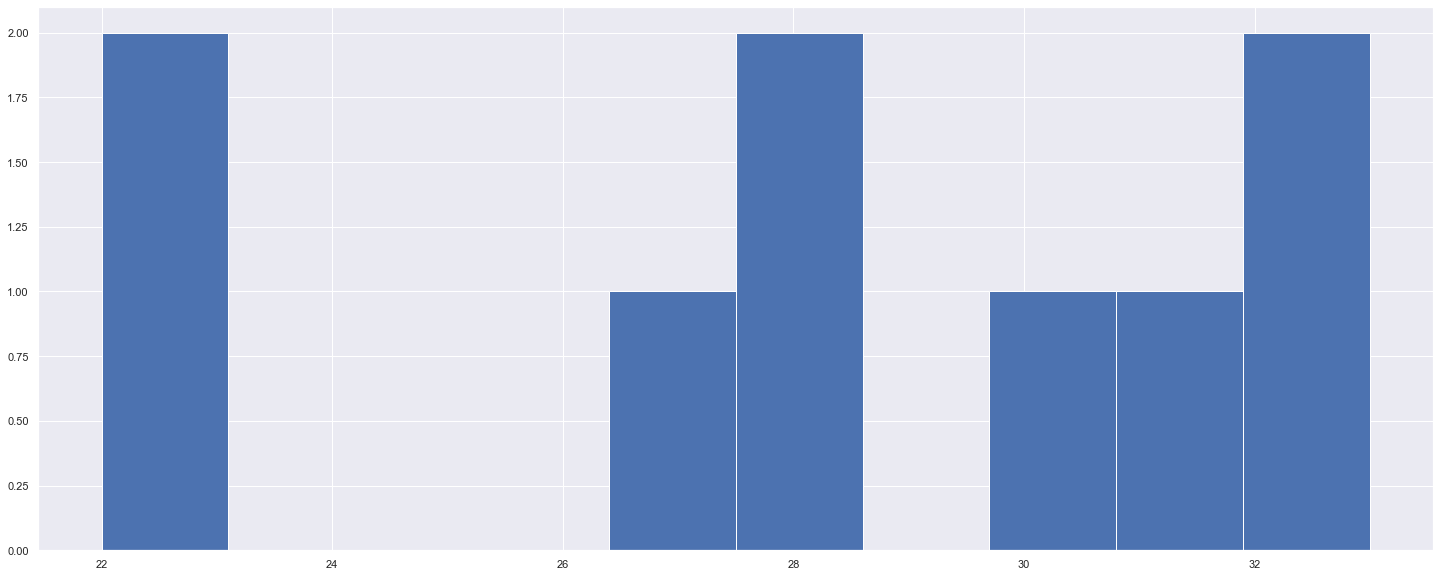

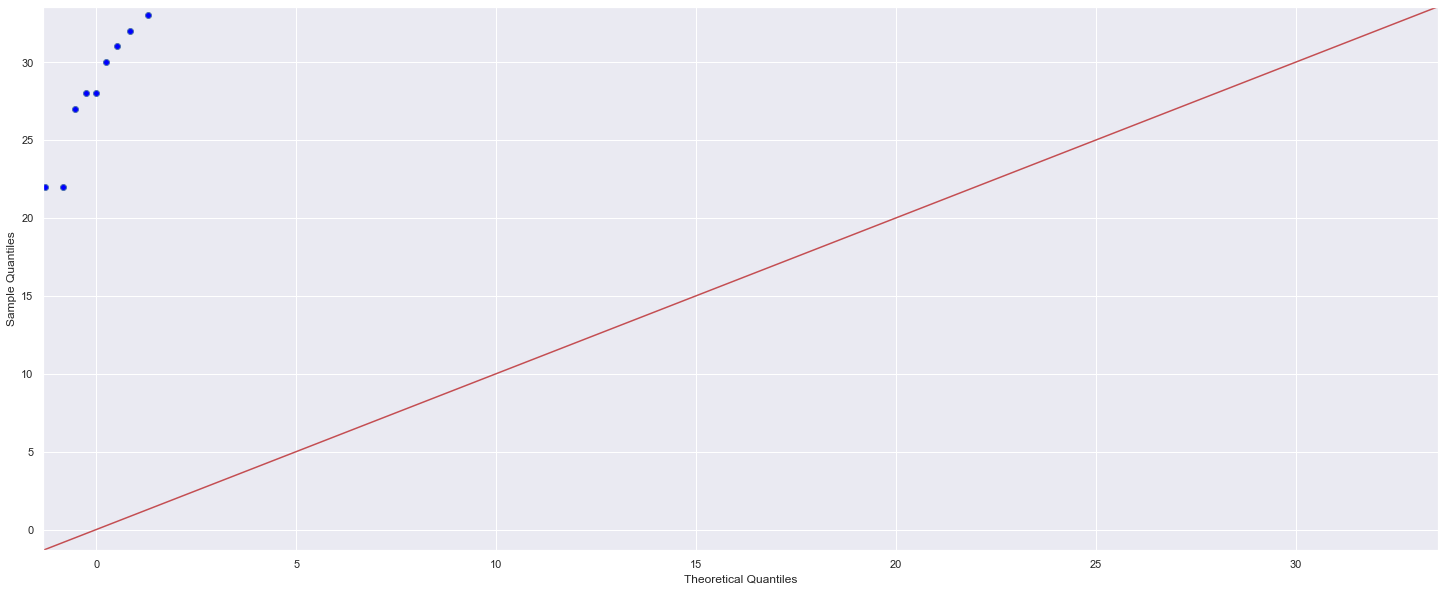

In [16]:
plt.hist(df4['Day3PostSAS'])
sm.qqplot(df4['Day3PostSAS'], line='45')
kstest(df4['Day3PostSAS'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=0.9986501019683699, pvalue=2.976724708040633e-26)

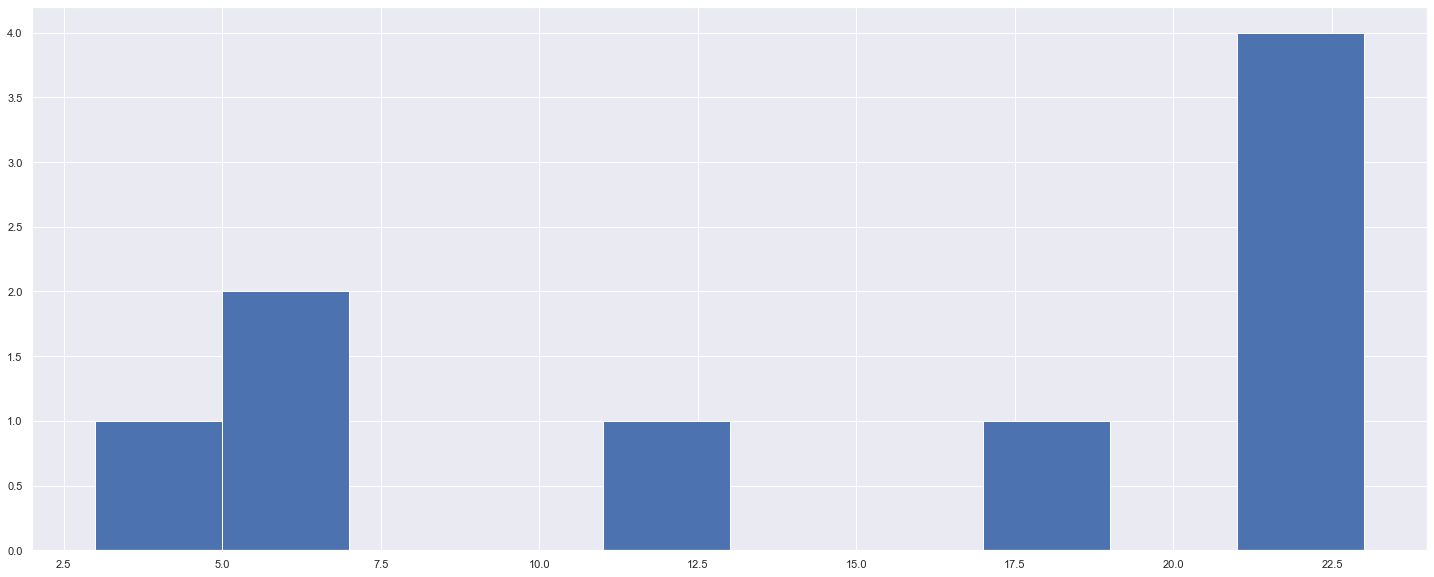

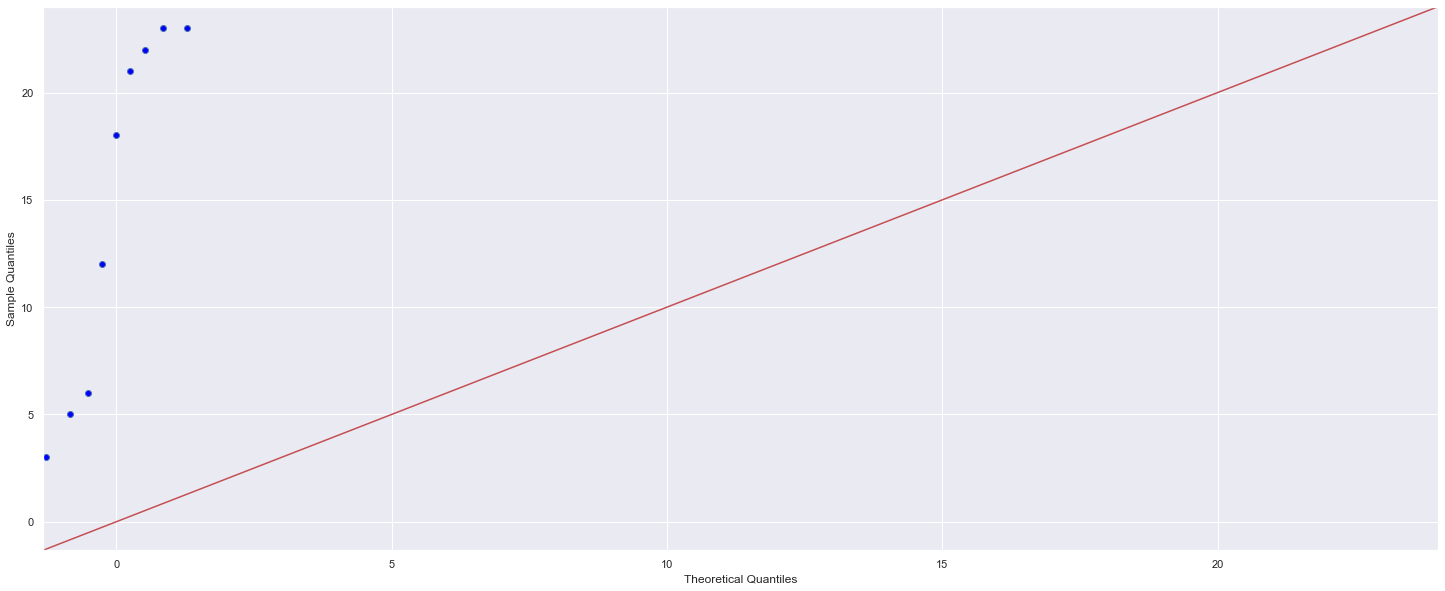

In [17]:
plt.hist(df4['Day1PreBAI'])
sm.qqplot(df4['Day1PreBAI'], line='45')
kstest(df4['Day1PreBAI'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=0.6191225238463207, pvalue=0.0007459255696515388)

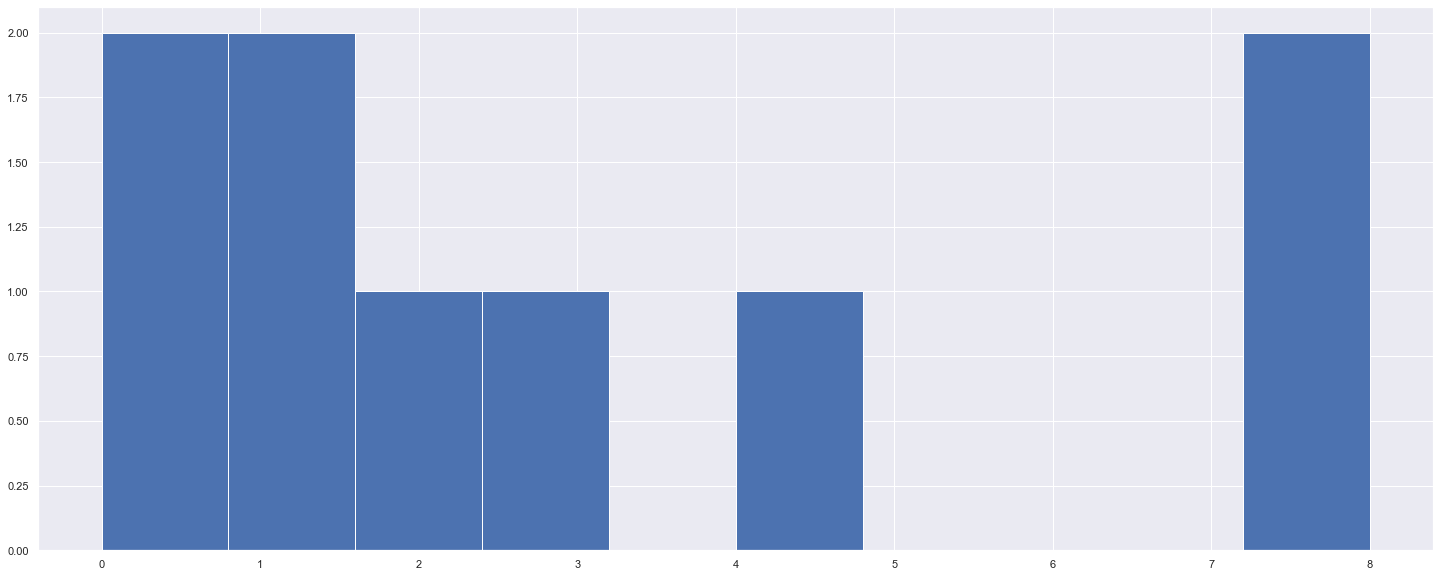

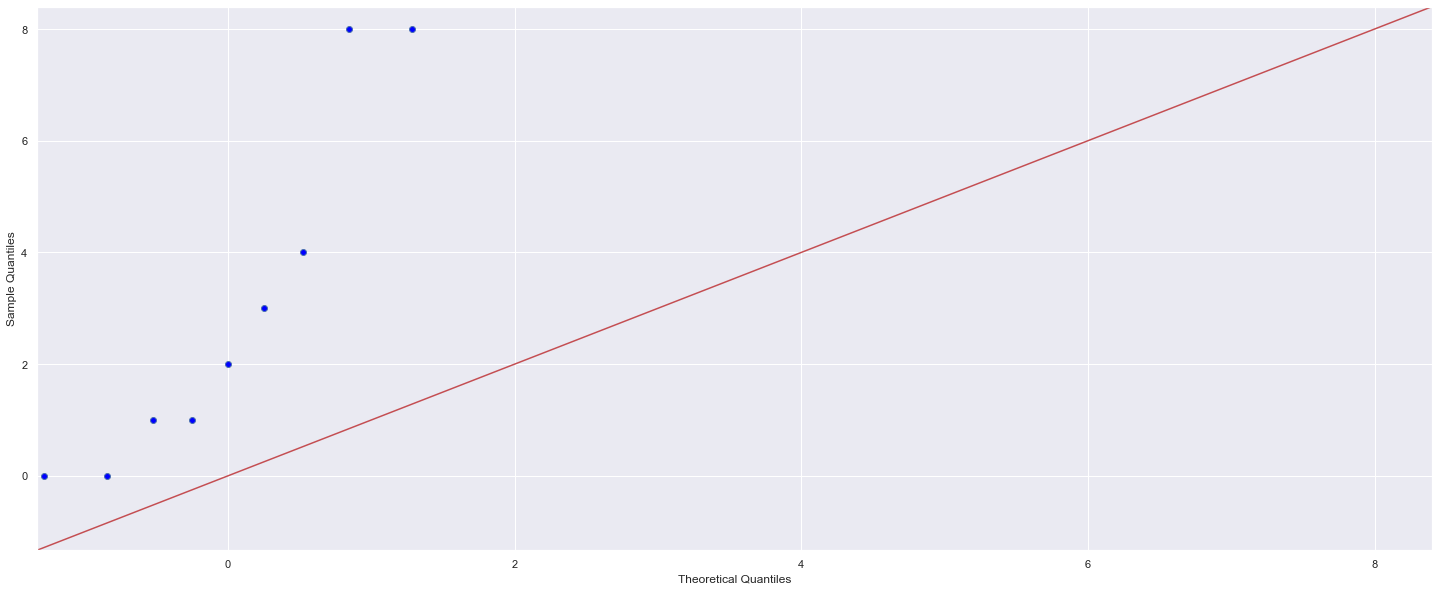

In [18]:
plt.hist(df4['Day3PostBAI_win'])
sm.qqplot(df4['Day3PostBAI_win'], line='45')
kstest(df4['Day3PostBAI_win'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=0.9999999999987201, pvalue=1.8429254784294847e-107)

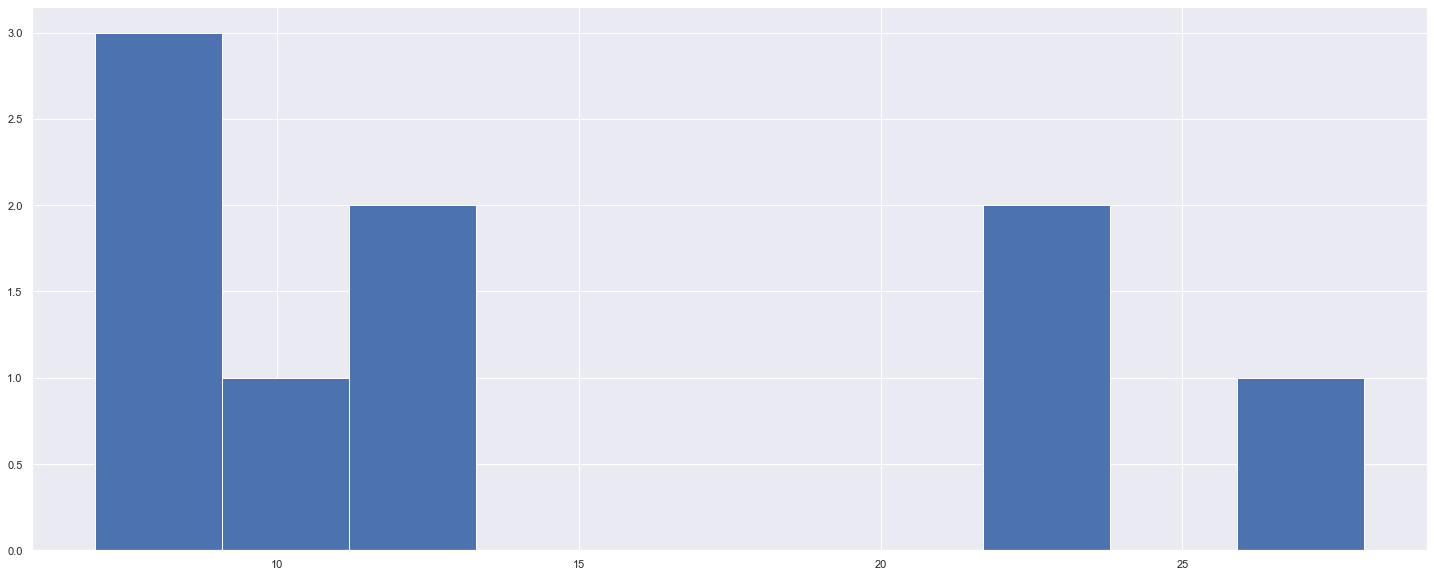

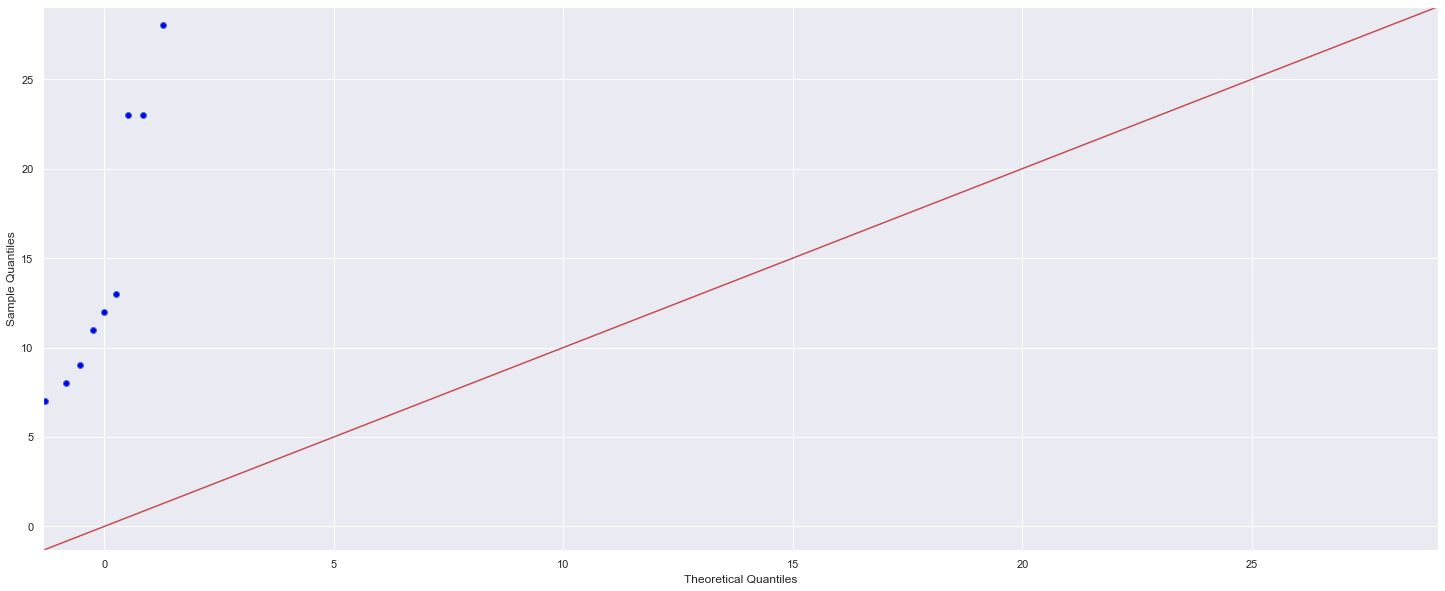

In [19]:
plt.hist(df4['Day1PreBDI'])
sm.qqplot(df4['Day1PreBDI'], line='45')
kstest(df4['Day1PreBDI'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=0.8661387569407097, pvalue=2.7602046369131942e-08)

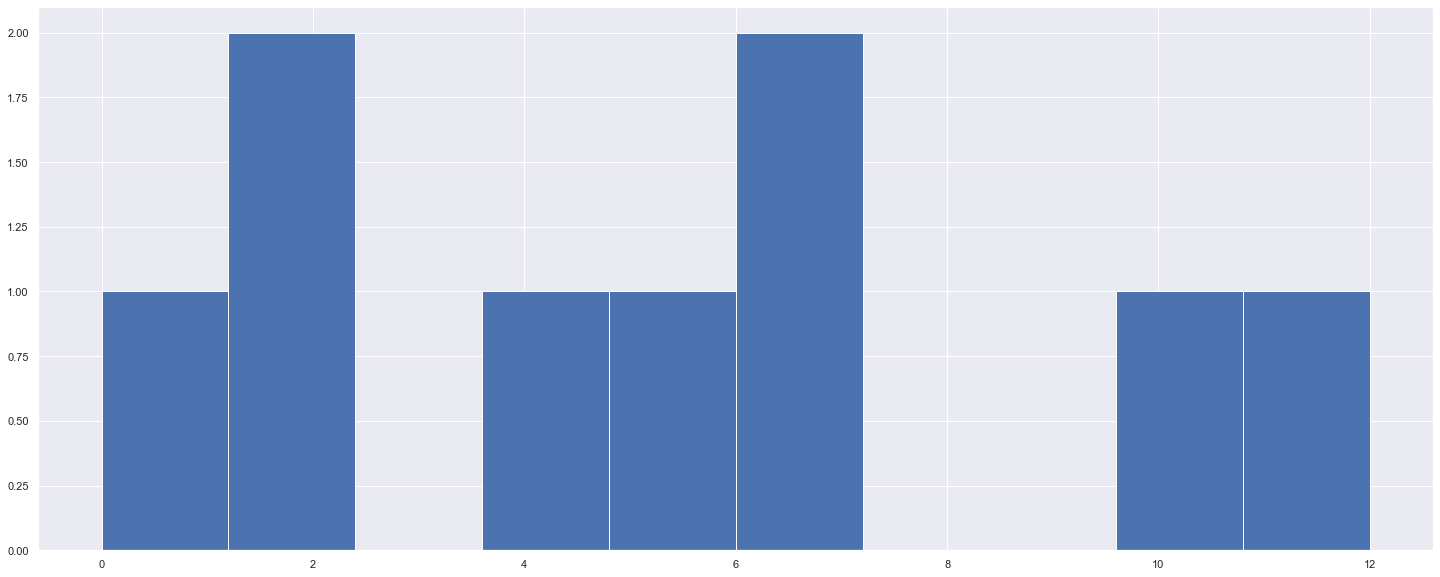

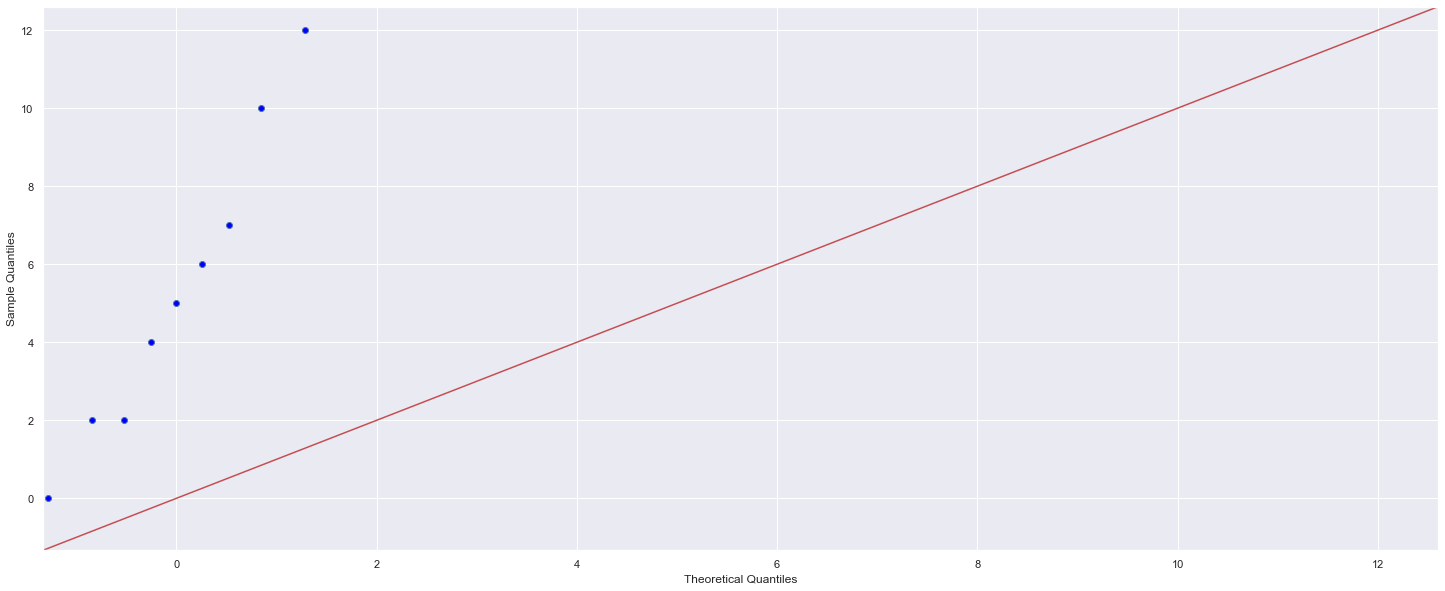

In [20]:
plt.hist(df4['Day3PostBDI'])
sm.qqplot(df4['Day3PostBDI'], line='45')
kstest(df4['Day3PostBDI'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=1.0, pvalue=0.0)

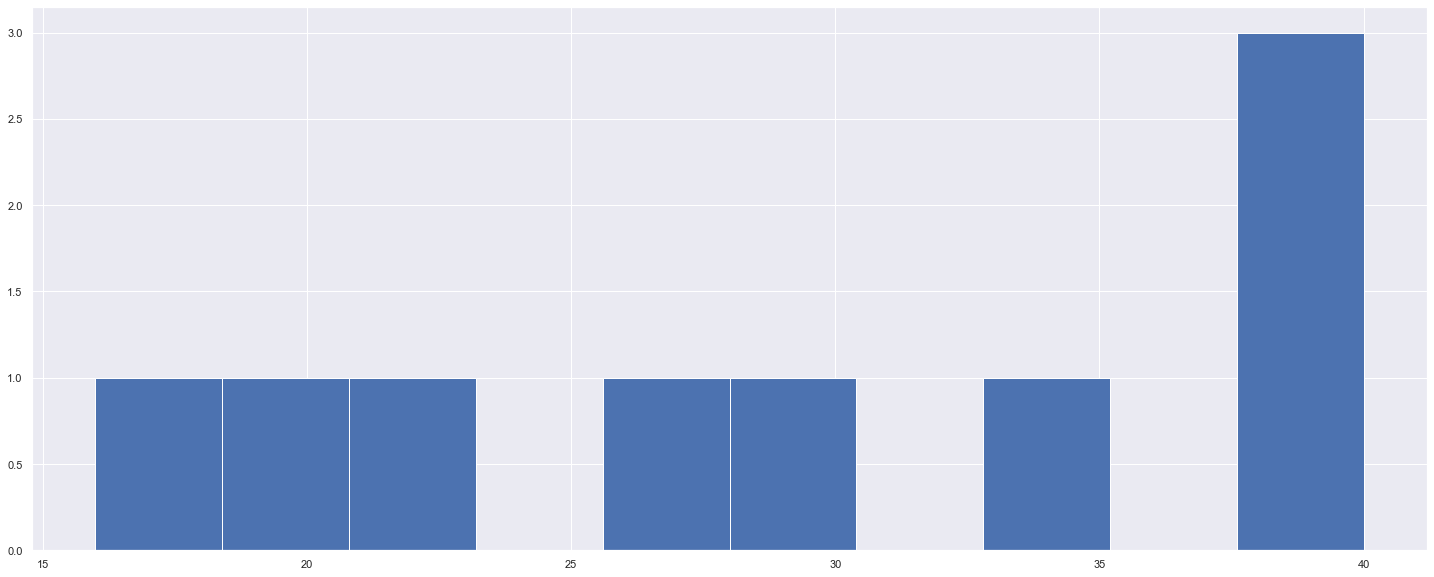

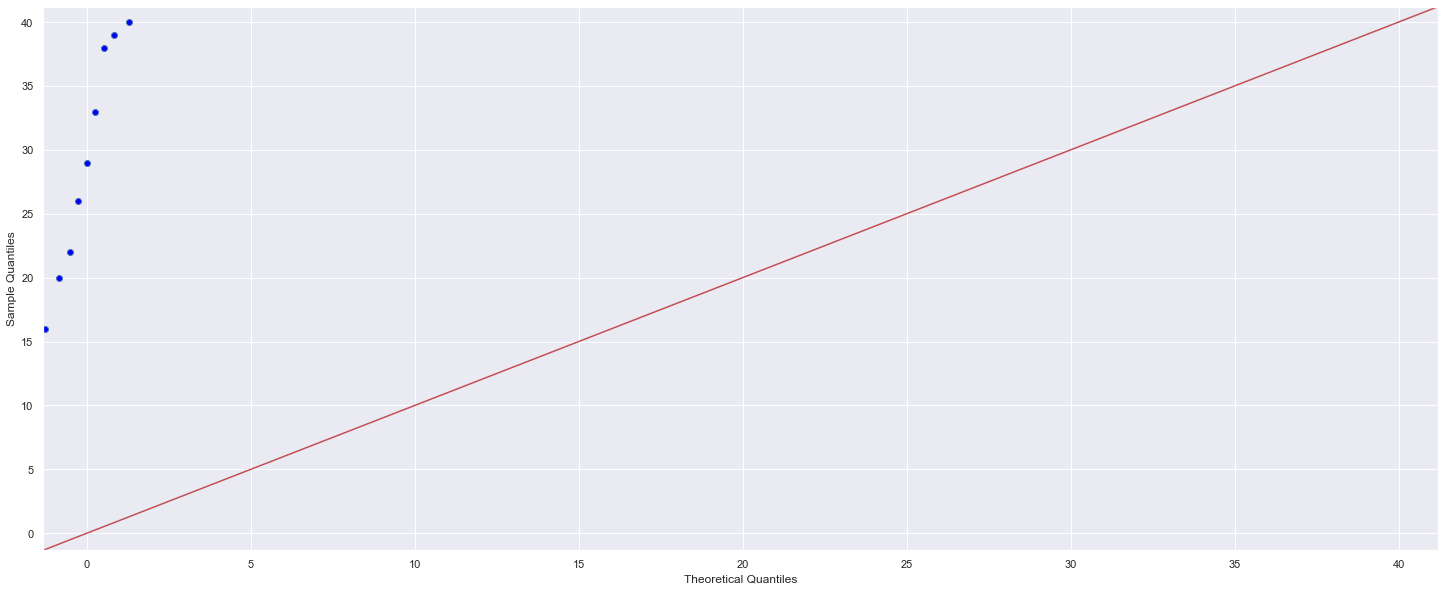

In [21]:
plt.hist(df4['Day1PrePANAS_P'])
sm.qqplot(df4['Day1PrePANAS_P'], line='45')
kstest(df4['Day1PrePANAS_P'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=1.0, pvalue=0.0)

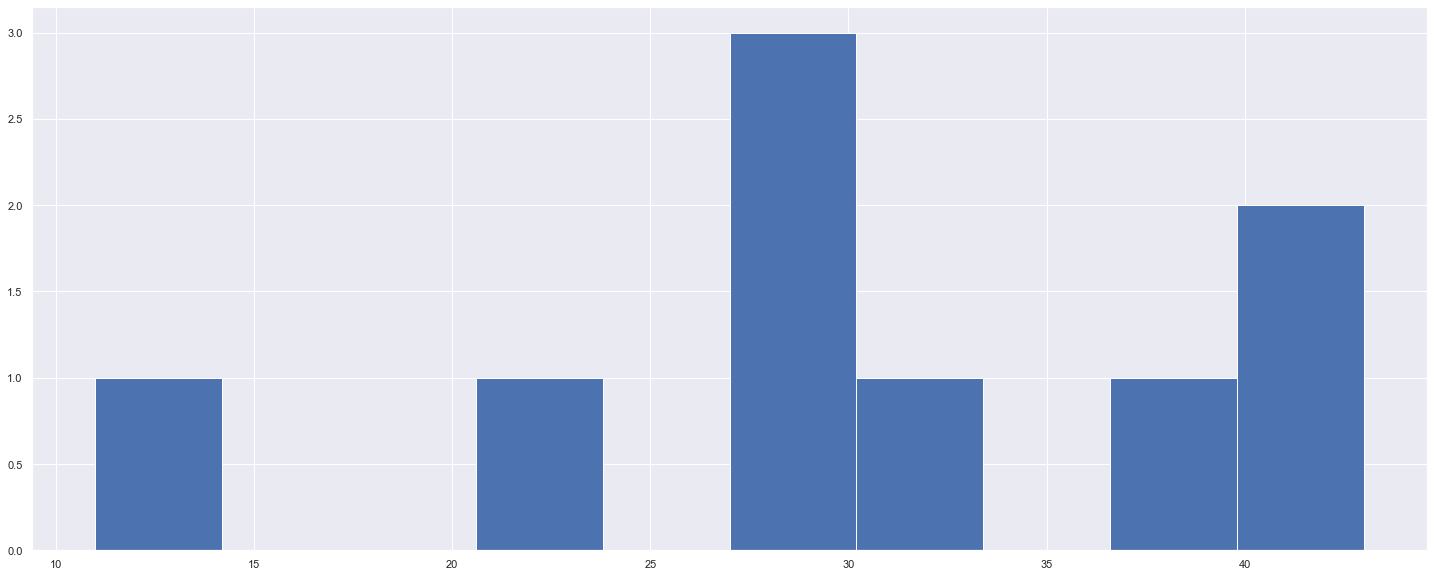

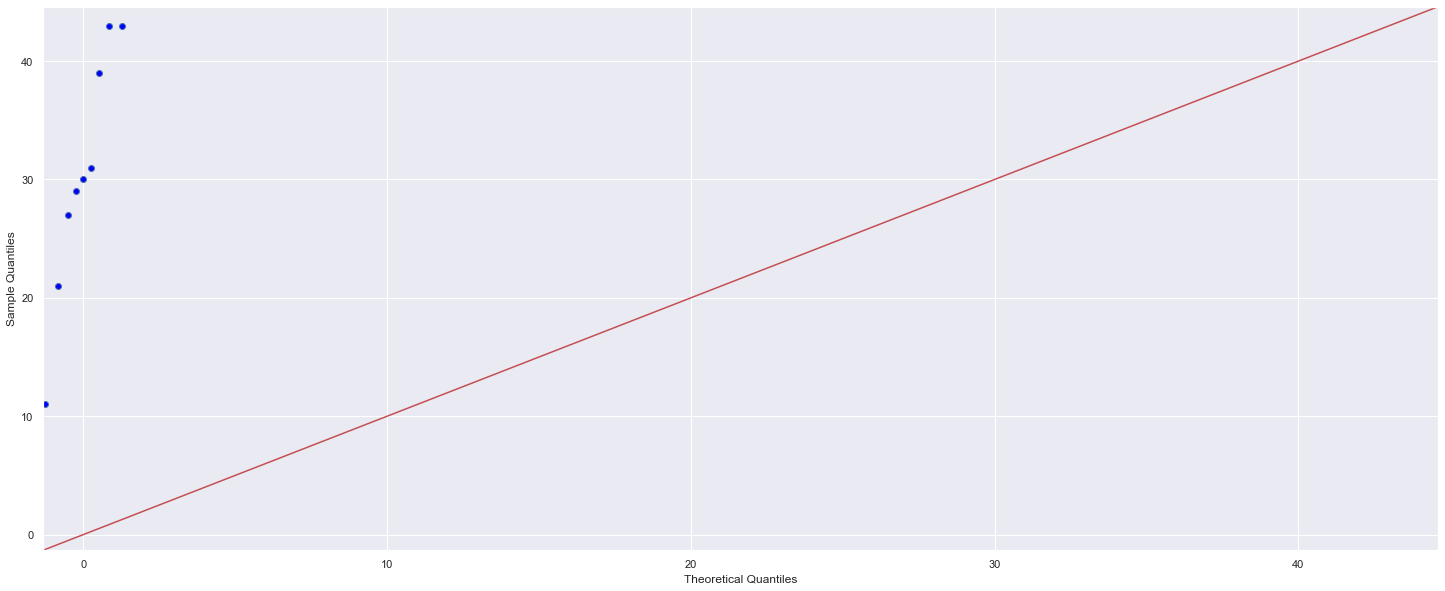

In [22]:
plt.hist(df4['Day3PostPANAS_P'])
sm.qqplot(df4['Day3PostPANAS_P'], line='45')
kstest(df4['Day3PostPANAS_P'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=0.5554342292188321, pvalue=0.003859940234171426)

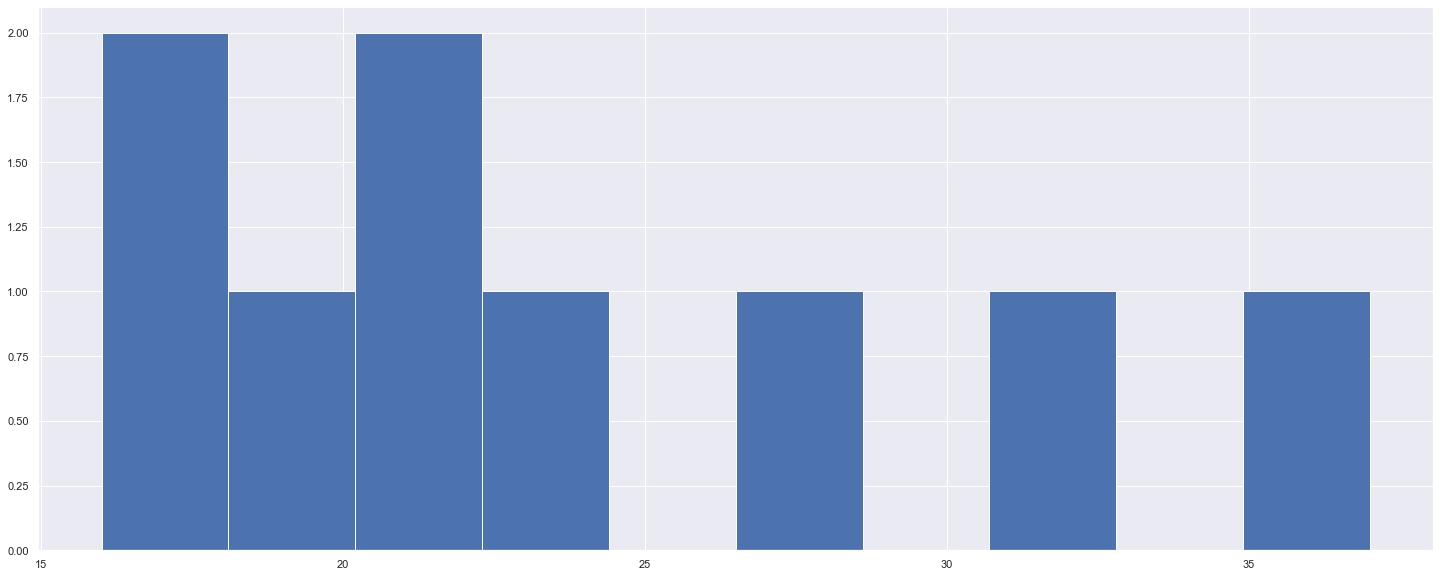

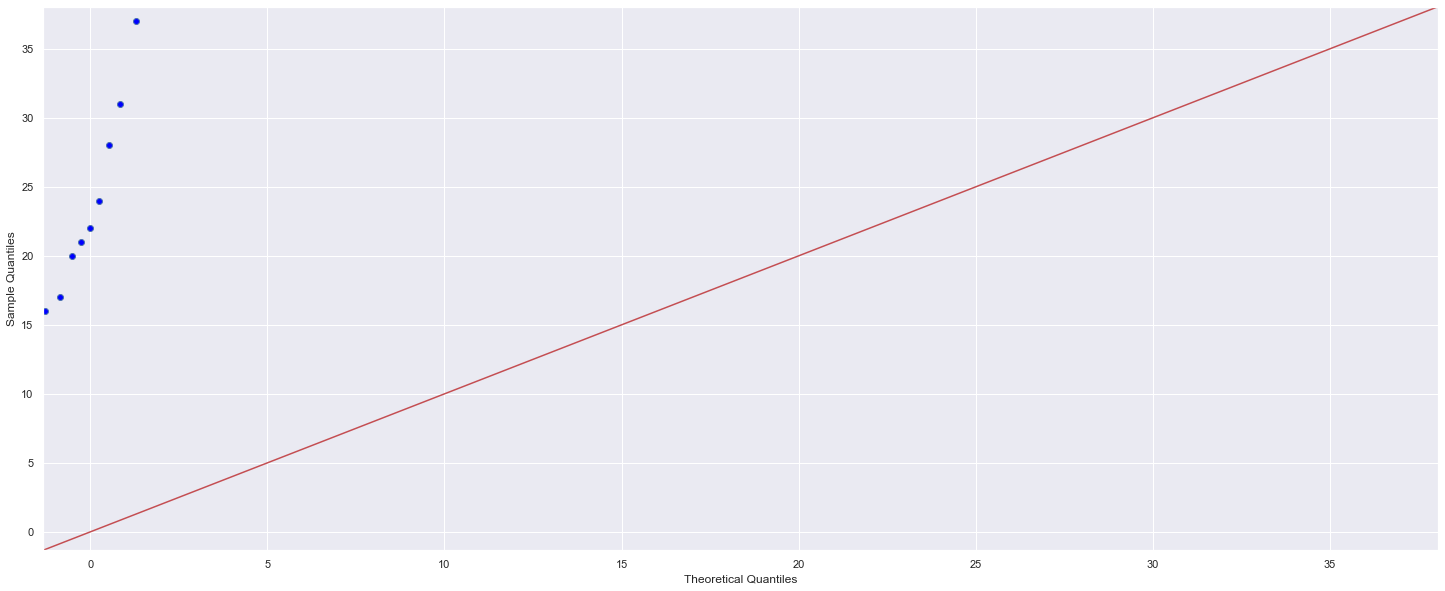

In [23]:
plt.hist(df4['Day1PrePANAS_N'])
sm.qqplot(df4['Day1PrePANAS_N'], line='45')
kstest(df4['Day1PeakAsym_win'], 'norm')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


KstestResult(statistic=1.0, pvalue=0.0)

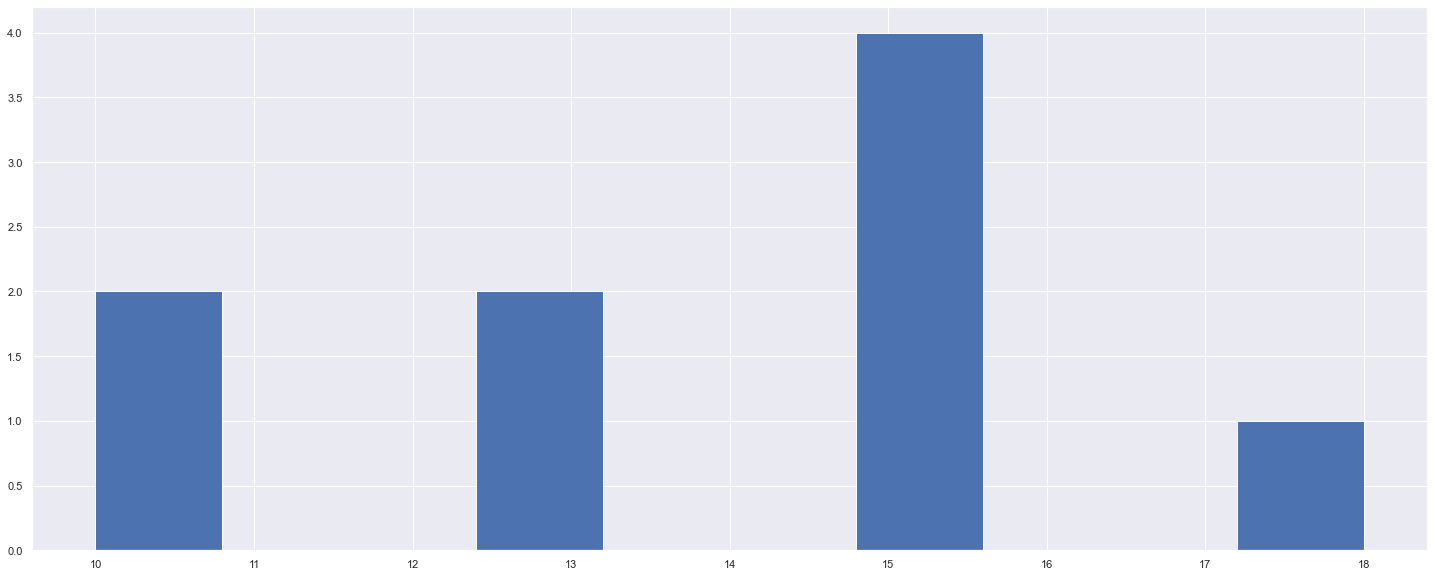

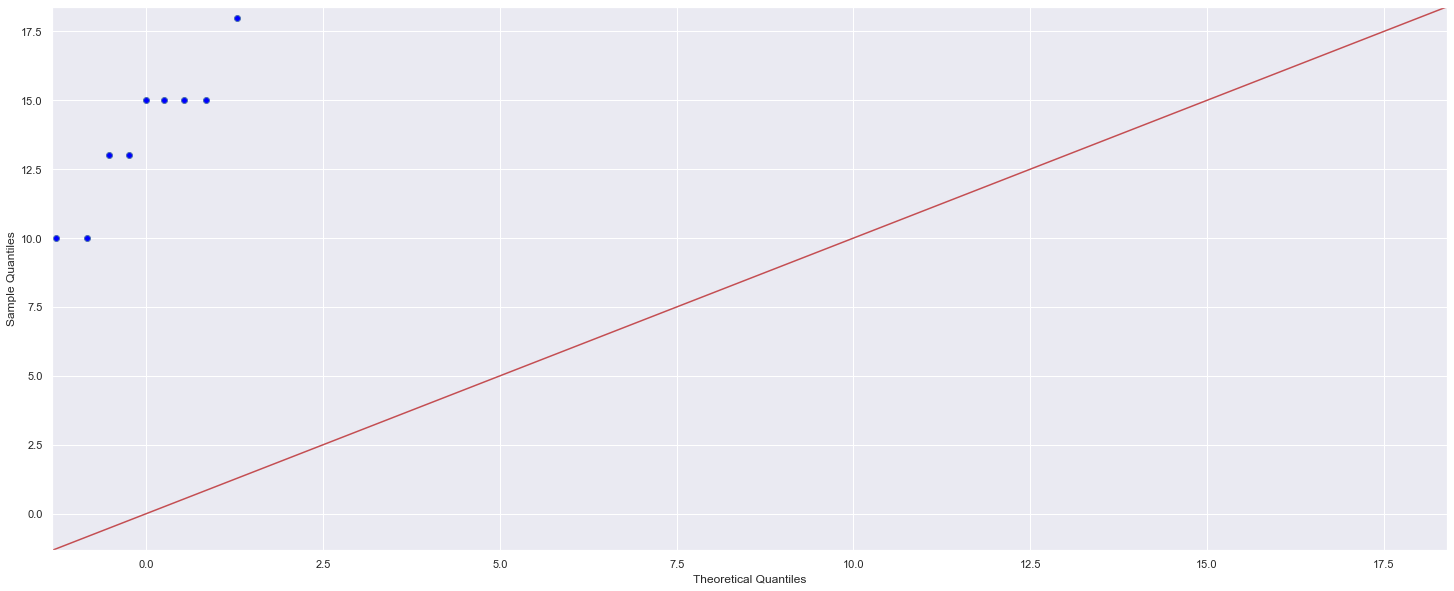

In [24]:
plt.hist(df4['Day3PostPANAS_N'])
sm.qqplot(df4['Day3PostPANAS_N'], line='45')
kstest(df4['Day3PostPANAS_N'], 'norm')

Across all variables, p values varied, histograms and QQ plots suggested deviations from normality across all variables. Boxplots also confirmed that none of these variables are normally distributed. 8 cases is likely to mean the p value for normality tests are unstable.

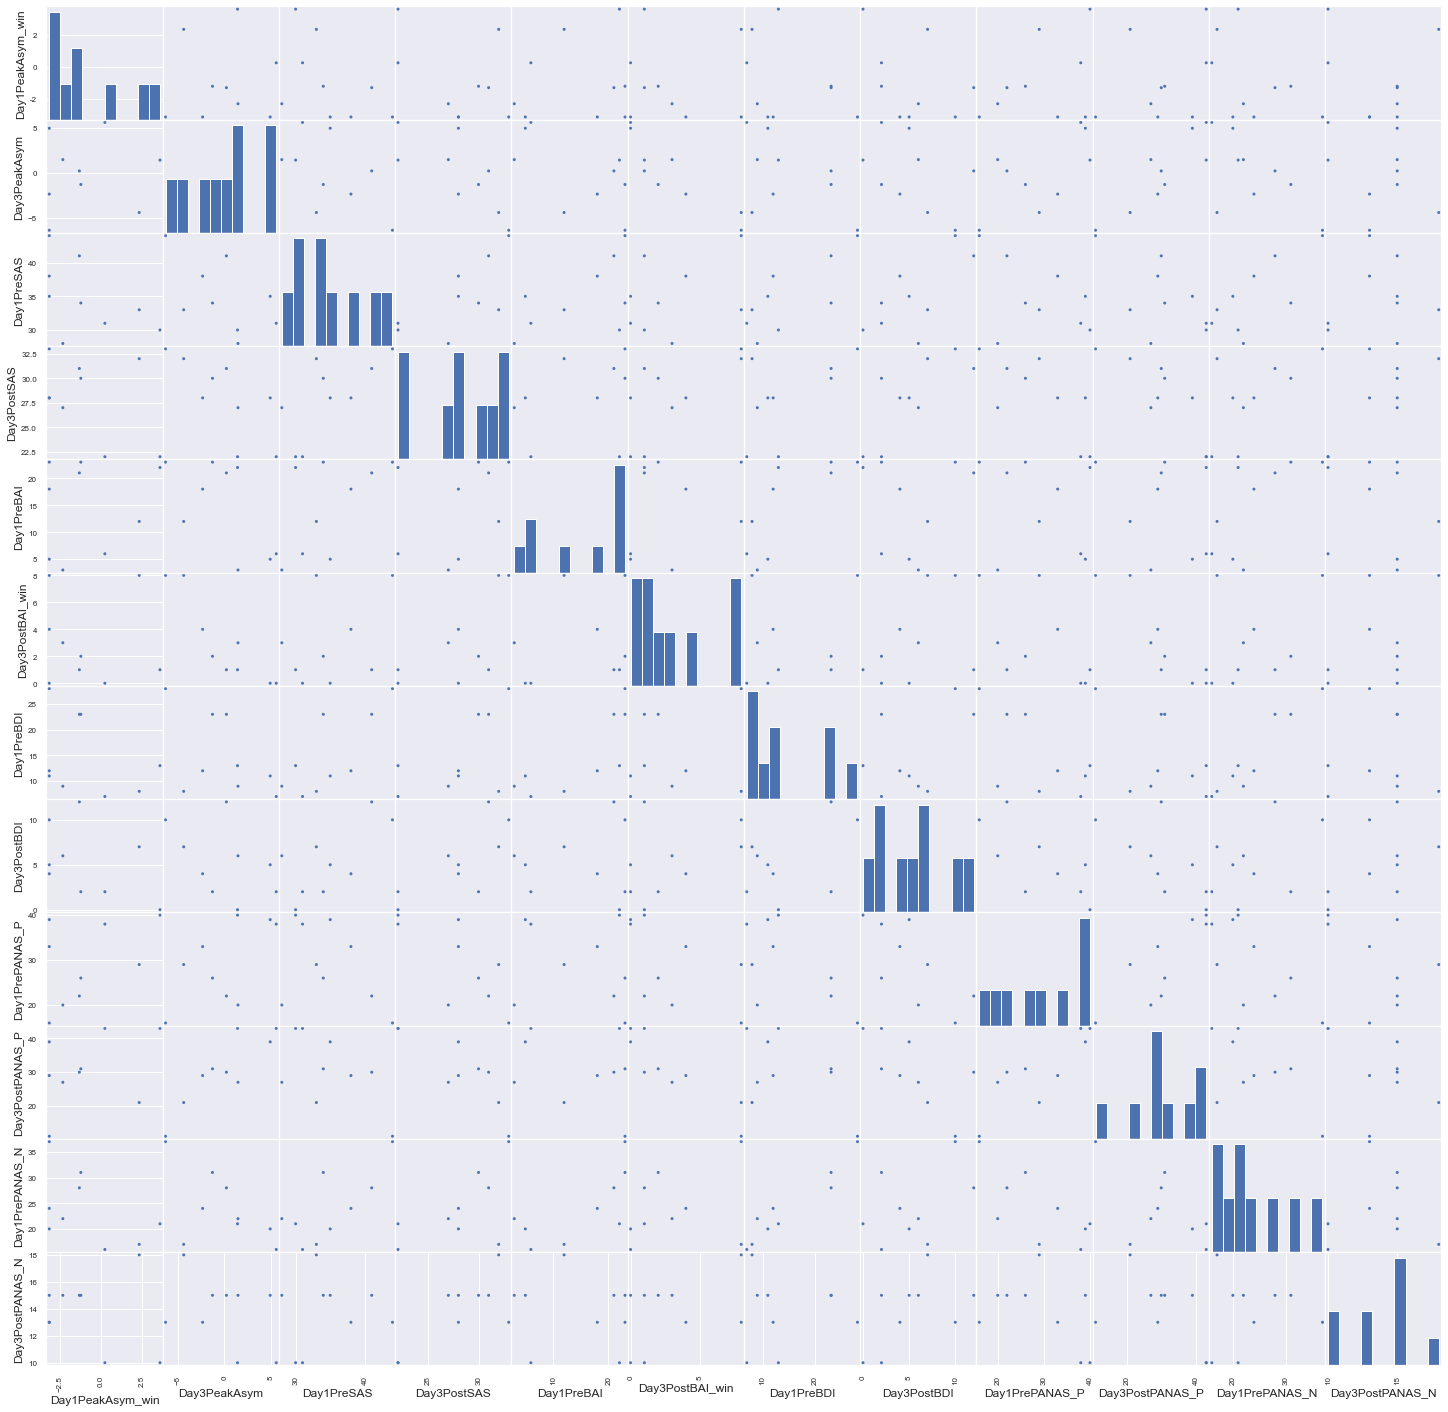

In [25]:
#Linearity
pd.plotting.scatter_matrix(df4[['Day1PeakAsym_win', 'Day3PeakAsym', 'Day1PreSAS', 'Day3PostSAS', 'Day1PreBAI', 'Day3PostBAI_win', 'Day1PreBDI',
            'Day3PostBDI', 'Day1PrePANAS_P', 'Day3PostPANAS_P', 'Day1PrePANAS_N', 'Day3PostPANAS_N']],
                           alpha = 1, figsize = [25, 25]);

In [26]:
spearmancorr1 = spearmanr(df4[['Day1PeakAsym_win', 'Day3PeakAsym', 'Day1PreSAS', 'Day3PostSAS', 'Day1PreBAI', 'Day3PostBAI_win', 'Day1PreBDI',
            'Day3PostBDI', 'Day1PrePANAS_P', 'Day3PostPANAS_P', 'Day1PrePANAS_N', 'Day3PostPANAS_N']], axis = 0)
display(spearmancorr1)

SpearmanrResult(correlation=array([[ 1.        ,  0.15256429, -0.61025715, -0.30770355,  0.11915865,
        -0.16309163, -0.29789662, -0.41705526,  0.37293493,  0.40854393,
        -0.45769286, -0.08040844],
       [ 0.15256429,  1.        , -0.55      , -0.80675117, -0.62762056,
        -0.88614695, -0.52720127, -0.42678198,  0.5       ,  0.76151294,
        -0.58333333, -0.25473903],
       [-0.61025715, -0.55      ,  1.        ,  0.72271459,  0.4853599 ,
         0.23630585,  0.6443571 ,  0.55230609, -0.35      , -0.37657233,
         0.6       ,  0.07905694],
       [-0.30770355, -0.80675117,  0.72271459,  1.        ,  0.43882247,
         0.64255901,  0.49789473,  0.75528098, -0.63867801, -0.75950043,
         0.53783412,  0.56692694],
       [ 0.11915865, -0.62762056,  0.4853599 ,  0.43882247,  1.        ,
         0.30085826,  0.82773109, -0.05462185, -0.20920685, -0.09243697,
         0.69456675, -0.22934432],
       [-0.16309163, -0.88614695,  0.23630585,  0.64255901,  0.3008

Create dataframes to display these results in a slightly more paletable way: 

In [27]:
variables = ([['Day1PeakAsym_win', 'Day3PeakAsym', 'Day1PreSAS', 'Day3PostSAS', 'Day1PreBAI', 'Day3PostBAI_win', 'Day1PreBDI',
            'Day3PostBDI', 'Day1PrePANAS_P', 'Day3PostPANAS_P', 'Day1PrePANAS_N', 'Day3PostPANAS_N']])

corvals = pd.DataFrame([[1.        ,  0.15256429, -0.61025715, -0.30770355,  0.11915865,
        -0.16309163, -0.29789662, -0.41705526,  0.37293493,  0.40854393,
        -0.45769286, -0.08040844],
       [ 0.15256429,  1.        , -0.55      , -0.80675117, -0.62762056,
        -0.88614695, -0.52720127, -0.42678198,  0.5       ,  0.76151294,
        -0.58333333, -0.25473903],
       [-0.61025715, -0.55      ,  1.        ,  0.72271459,  0.4853599 ,
         0.23630585,  0.6443571 ,  0.55230609, -0.35      , -0.37657233,
         0.6       ,  0.07905694],
       [-0.30770355, -0.80675117,  0.72271459,  1.        ,  0.43882247,
         0.64255901,  0.49789473,  0.75528098, -0.63867801, -0.75950043,
         0.53783412,  0.56692694],
       [ 0.11915865, -0.62762056,  0.4853599 ,  0.43882247,  1.        ,
         0.30085826,  0.82773109, -0.05462185, -0.20920685, -0.09243697,
         0.69456675, -0.22934432],
       [-0.16309163, -0.88614695,  0.23630585,  0.64255901,  0.30085826,
         1.        ,  0.23305922,  0.42798147, -0.59920413, -0.89833734,
         0.42197474,  0.30691229],
       [-0.29789662, -0.52720127,  0.6443571 ,  0.49789473,  0.82773109,
         0.23305922,  1.        ,  0.23109244, -0.41004543, -0.21848739,
         0.91214188, -0.07938842],
       [-0.41705526, -0.42678198,  0.55230609,  0.75528098, -0.05462185,
         0.42798147,  0.23109244,  1.        , -0.7113033 , -0.74369748,
         0.32636269,  0.55571893],
       [ 0.37293493,  0.5       , -0.35      , -0.63867801, -0.20920685,
        -0.59920413, -0.41004543, -0.7113033 ,  1.        ,  0.78661776,
        -0.66666667, -0.36893239],
       [ 0.40854393,  0.76151294, -0.37657233, -0.75950043, -0.09243697,
        -0.89833734, -0.21848739, -0.74369748,  0.78661776,  1.        ,
        -0.44351853, -0.48515145],
       [-0.45769286, -0.58333333,  0.6       ,  0.53783412,  0.69456675,
         0.42197474,  0.91214188,  0.32636269, -0.66666667, -0.44351853,
         1.        ,  0.04392052],
       [-0.08040844, -0.25473903,  0.07905694,  0.56692694, -0.22934432,
         0.30691229, -0.07938842,  0.55571893, -0.36893239, -0.48515145,
         0.04392052,  1.        ]], variables, variables)

pvals = pd.DataFrame([[0.00000000e+00, 6.95164092e-01, 8.09396701e-02, 4.20527287e-01,
        7.60105950e-01, 6.75029099e-01, 4.36236135e-01, 2.64094827e-01,
        3.22898563e-01, 2.74963884e-01, 2.15411703e-01, 8.37073284e-01],
       [6.95164092e-01, 0.00000000e+00, 1.24976784e-01, 8.59808327e-03,
        7.03650228e-02, 1.46441911e-03, 1.44699332e-01, 2.51956690e-01,
        1.70470661e-01, 1.71171255e-02, 9.91858165e-02, 5.08299873e-01],
       [8.09396701e-02, 1.24976784e-01, 0.00000000e+00, 2.78302399e-02,
        1.85353818e-01, 5.40443782e-01, 6.10329577e-02, 1.23076630e-01,
        3.55819573e-01, 3.17822682e-01, 8.76228290e-02, 8.39782984e-01],
       [4.20527287e-01, 8.59808327e-03, 2.78302399e-02, 0.00000000e+00,
        2.37352707e-01, 6.19957144e-02, 1.72567247e-01, 1.86107044e-02,
        6.41062083e-02, 1.75903842e-02, 1.35288910e-01, 1.11431747e-01],
       [7.60105950e-01, 7.03650228e-02, 1.85353818e-01, 2.37352707e-01,
        0.00000000e+00, 4.31465115e-01, 5.87748490e-03, 8.89001573e-01,
        5.89047241e-01, 8.13024659e-01, 3.78640538e-02, 5.52781099e-01],
       [6.75029099e-01, 1.46441911e-03, 5.40443782e-01, 6.19957144e-02,
        4.31465115e-01, 4.74758611e-56, 5.46184354e-01, 2.50480845e-01,
        8.81551018e-02, 9.97418051e-04, 2.57917859e-01, 4.21785170e-01],
       [4.36236135e-01, 1.44699332e-01, 6.10329577e-02, 1.72567247e-01,
        5.87748490e-03, 5.46184354e-01, 0.00000000e+00, 5.49673144e-01,
        2.73029747e-01, 5.72229255e-01, 6.06850679e-04, 8.39118250e-01],
       [2.64094827e-01, 2.51956690e-01, 1.23076630e-01, 1.86107044e-02,
        8.89001573e-01, 2.50480845e-01, 5.49673144e-01, 0.00000000e+00,
        3.16565570e-02, 2.16118918e-02, 3.91360449e-01, 1.20296343e-01],
       [3.22898563e-01, 1.70470661e-01, 3.55819573e-01, 6.41062083e-02,
        5.89047241e-01, 8.81551018e-02, 2.73029747e-01, 3.16565570e-02,
        0.00000000e+00, 1.19092120e-02, 4.98672306e-02, 3.28530352e-01],
       [2.74963884e-01, 1.71171255e-02, 3.17822682e-01, 1.75903842e-02,
        8.13024659e-01, 9.97418051e-04, 5.72229255e-01, 2.16118918e-02,
        1.19092120e-02, 0.00000000e+00, 2.31784065e-01, 1.85570845e-01],
       [2.15411703e-01, 9.91858165e-02, 8.76228290e-02, 1.35288910e-01,
        3.78640538e-02, 2.57917859e-01, 6.06850679e-04, 3.91360449e-01,
        4.98672306e-02, 2.31784065e-01, 0.00000000e+00, 9.10669551e-01],
       [8.37073284e-01, 5.08299873e-01, 8.39782984e-01, 1.11431747e-01,
        5.52781099e-01, 4.21785170e-01, 8.39118250e-01, 1.20296343e-01,
        3.28530352e-01, 1.85570845e-01, 9.10669551e-01, 0.00000000e+00]], variables, variables)

In [28]:
display(corvals)
# Correlaton coefficients

,Day1PeakAsym_win,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI_win,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N
Day1PeakAsym_win,1.000000,0.152564,-0.610257,-0.307704,0.119159,-0.163092,-0.297897,-0.417055,0.372935,0.408544,-0.457693,-0.080408
Day3PeakAsym,0.152564,1.000000,-0.550000,-0.806751,-0.627621,-0.886147,-0.527201,-0.426782,0.500000,0.761513,-0.583333,-0.254739
Day1PreSAS,-0.610257,-0.550000,1.000000,0.722715,0.485360,0.236306,0.644357,0.552306,-0.350000,-0.376572,0.600000,0.079057
Day3PostSAS,-0.307704,-0.806751,0.722715,1.000000,0.438822,0.642559,0.497895,0.755281,-0.638678,-0.759500,0.537834,0.566927
Day1PreBAI,0.119159,-0.627621,0.485360,0.438822,1.000000,0.300858,0.827731,-0.054622,-0.209207,-0.092437,0.694567,-0.229344
Day3PostBAI_win,-0.163092,-0.886147,0.236306,0.642559,0.300858,1.000000,0.233059,0.427981,-0.599204,-0.898337,0.421975,0.306912
Day1PreBDI,-0.297897,-0.527201,0.644357,0.497895,0.827731,0.233059,1.000000,0.231092,-0.410045,-0.218487,0.912142,-0.079388
Day3PostBDI,-0.417055,-0.426782,0.552306,0.755281,-0.054622,0.427981,0.231092,1.000000,-0.711303,-0.743697,0.326363,0.555719
Day1PrePANAS_P,0.372935,0.500000,-0.350000,-0.638678,-0.209207,-0.599204,-0.410045,-0.711303,1.000000,0.786618,-0.666667,-0.368932
Day3PostPANAS_P,0.408544,0.761513,-0.376572,-0.759500,-0.092437,-0.898337,-0.218487,-0.743697,0.786618,1.000000,-0.443519,-0.485151


In [29]:
display(pvals)
# P values

,Day1PeakAsym_win,Day3PeakAsym,Day1PreSAS,Day3PostSAS,Day1PreBAI,Day3PostBAI_win,Day1PreBDI,Day3PostBDI,Day1PrePANAS_P,Day3PostPANAS_P,Day1PrePANAS_N,Day3PostPANAS_N
Day1PeakAsym_win,0.000000,0.695164,0.080940,0.420527,0.760106,6.750291e-01,0.436236,0.264095,0.322899,0.274964,0.215412,0.837073
Day3PeakAsym,0.695164,0.000000,0.124977,0.008598,0.070365,1.464419e-03,0.144699,0.251957,0.170471,0.017117,0.099186,0.508300
Day1PreSAS,0.080940,0.124977,0.000000,0.027830,0.185354,5.404438e-01,0.061033,0.123077,0.355820,0.317823,0.087623,0.839783
Day3PostSAS,0.420527,0.008598,0.027830,0.000000,0.237353,6.199571e-02,0.172567,0.018611,0.064106,0.017590,0.135289,0.111432
Day1PreBAI,0.760106,0.070365,0.185354,0.237353,0.000000,4.314651e-01,0.005877,0.889002,0.589047,0.813025,0.037864,0.552781
Day3PostBAI_win,0.675029,0.001464,0.540444,0.061996,0.431465,4.747586e-56,0.546184,0.250481,0.088155,0.000997,0.257918,0.421785
Day1PreBDI,0.436236,0.144699,0.061033,0.172567,0.005877,5.461844e-01,0.000000,0.549673,0.273030,0.572229,0.000607,0.839118
Day3PostBDI,0.264095,0.251957,0.123077,0.018611,0.889002,2.504808e-01,0.549673,0.000000,0.031657,0.021612,0.391360,0.120296
Day1PrePANAS_P,0.322899,0.170471,0.355820,0.064106,0.589047,8.815510e-02,0.273030,0.031657,0.000000,0.011909,0.049867,0.328530
Day3PostPANAS_P,0.274964,0.017117,0.317823,0.017590,0.813025,9.974181e-04,0.572229,0.021612,0.011909,0.000000,0.231784,0.185571


<AxesSubplot:xlabel='None', ylabel='None'>

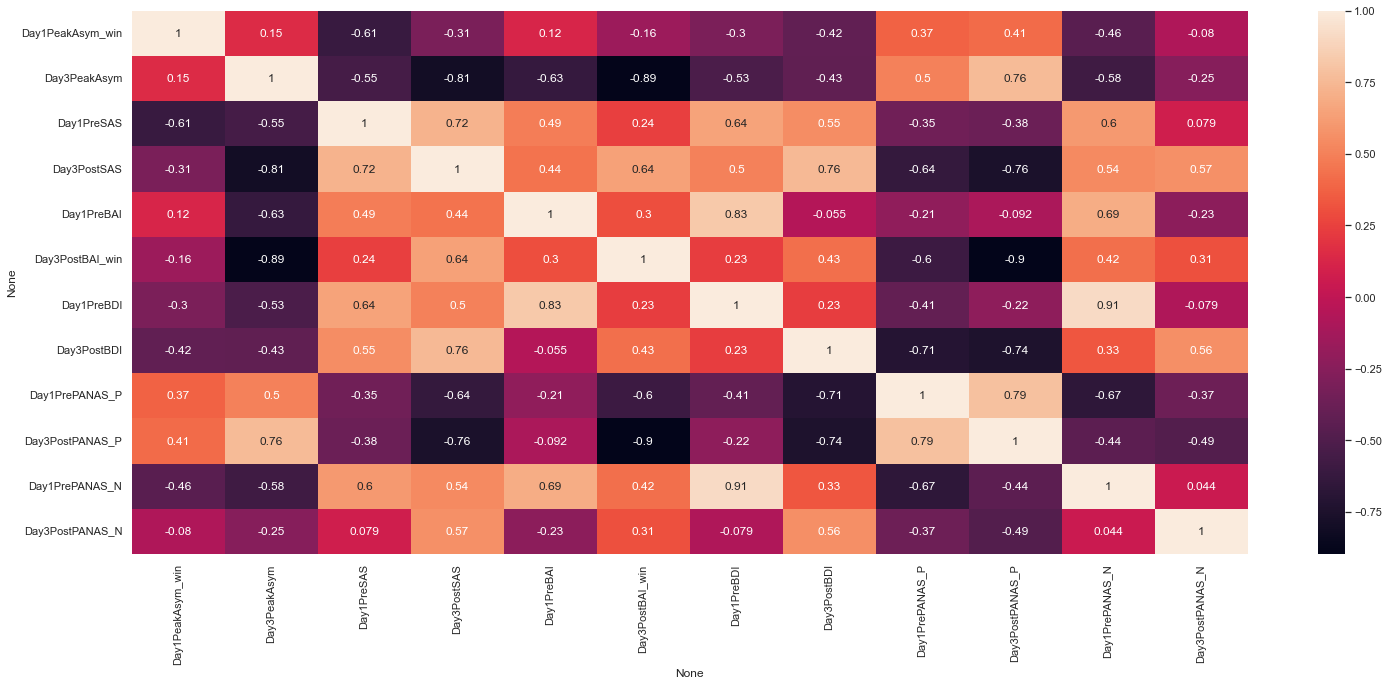

In [30]:
#Heatmaps to make correlations easier to visualise
sns.heatmap(corvals, annot = True)

<AxesSubplot:xlabel='None', ylabel='None'>

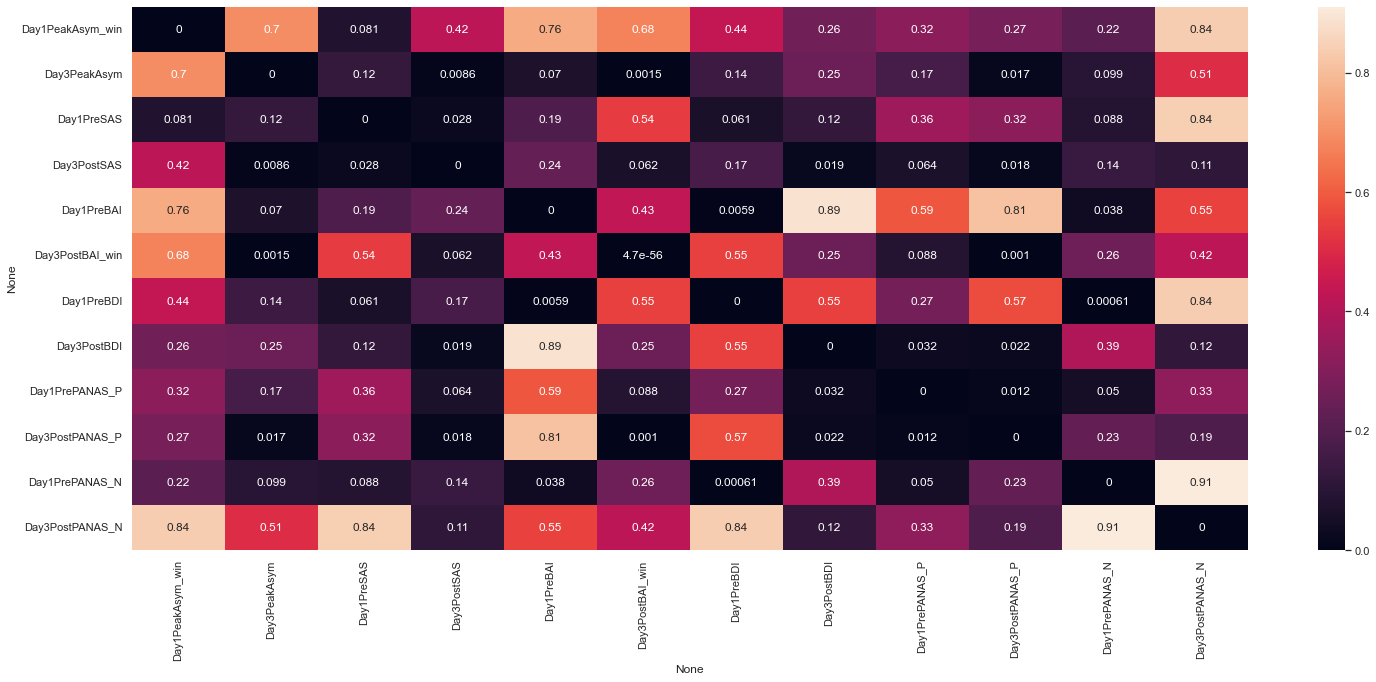

In [31]:
sns.heatmap(pvals, annot = True)

The correlations show the following:
significant correlations for 

Day3PostSAS & Day3PeakAsym

Day3PostBAI_win & Day3PostPANAS_P

Day3PostSAS & Day1PreSAS

Day3PostBDI & Day3PostSAS

Day3PostPANAS_P & Day3PostSAS 

Day1PreBDI & Day1PreBAI

Day3PostPANAS_P & Day3PostBAI_win

Day1PrePANAS_N & Day1PreBDI

Day1PrePANAS_P & Day3PostBDI

Day3PostPANAS_P & Day3PostBDI

Day3PostPANAS_P & Day1PrePANAS_P

Day1PrePANAS_N & Day1PrePANAS_P

Wilcoxon Signed Ranks Test

In [32]:
wilcoxon(df4['Day1PeakAsym_win'], df4['Day3PeakAsym'], mode = 'approx')

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=18.0, pvalue=0.5939546753269146)

In [33]:
wilcoxon(df4['Day1PreSAS'], df4['Day3PostSAS'], mode = 'approx')

WilcoxonResult(statistic=0.0, pvalue=0.0075792819433897285)

In [34]:
wilcoxon(df4['Day1PreBAI'], df4['Day3PostBAI_win'], mode = 'approx')

WilcoxonResult(statistic=0.0, pvalue=0.011616044899262472)

In [35]:
wilcoxon(df4['Day1PreBDI'], df4['Day3PostBDI'], mode = 'approx')

WilcoxonResult(statistic=0.0, pvalue=0.007685794055213263)

In [36]:
wilcoxon(df4['Day1PrePANAS_P'], df4['Day3PostPANAS_P'], mode = 'approx')

WilcoxonResult(statistic=13.5, pvalue=0.5260658393071347)

In [37]:
wilcoxon(df4['Day1PrePANAS_N'], df4['Day3PostPANAS_N'], mode = 'approx')

WilcoxonResult(statistic=1.0, pvalue=0.010792782163388177)

In [38]:
np.mean(df4)

Day1PeakAsym_win    -0.897778
Day3PeakAsym        -0.067778
Day1PreSAS          34.888889
Day3PostSAS         28.111111
Day1PreBAI          14.777778
Day3PostBAI_win      3.000000
Day1PreBDI          14.888889
Day3PostBDI          5.333333
Day1PrePANAS_P      29.222222
Day3PostPANAS_P     30.444444
Day1PrePANAS_N      24.000000
Day3PostPANAS_N     13.777778
mahalanobis          7.651217
p                    0.732713
dtype: float64

Basically; tACS at 10Hz improved SAS scores, BAI scores, BDI scores, and PANAS_N scores. 

Observations of the means suggested:

SAS went down, BAI went down, BDI went down and PANAS_N went down.

# Regression

Assumptions:

Normality of the DV - however using an OLS model reduces the error variance of the summs of squares thus making normality a non-issue.
 
Homoscedasticity - This will be done by using Levene's test. If the data is normally distributed you can use Bartlett's test

Independence - don't do regressions with day1 and day3 of the same measure

Linearity - Linear relationships only - not enough cases to establish visually, best way to assess is by using significant correlations. 

Multicollinearity/Singularity - corrcoefs >.8 will need to be excluded. You can average collinear variables. 

Collinear Variables:
- Day1PreBDI and Day1PreBAI
- Day1PrePANAS_N and Day1PreBDI

Homoscedasticity via levene's test. 

Multiple regressions showed no results of interest. Likely because a MR requires 20N per predictor variable - and we're using 9

# Simple Linear Regressions

For the assumption of Homoscedasticity: The following regression models would have met the assumption:

In [39]:
#Levene's Test for Homoscedasticity
stats.levene(df4['Day1PeakAsym_win'], df4['Day1PreSAS'], center = 'mean')

LeveneResult(statistic=3.837413191570623, pvalue=0.06778516972749266)

In [40]:
stats.levene(df4['Day3PeakAsym'], df4['Day3PostSAS'], center = 'mean')

LeveneResult(statistic=0.009475825178985648, pvalue=0.9236623133511455)

In [41]:
reg1 = smf.ols('Day3PostSAS~Day3PeakAsym', data=df4).fit()
reg2 = smf.ols('Day1PreSAS~Day1PeakAsym_win', data=df4).fit()

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Day3PostSAS   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     8.837
Date:                Sat, 30 Jul 2022   Prob (F-statistic):             0.0207
Time:                        15:52:05   Log-Likelihood:                -21.004
No. Observations:                   9   AIC:                             46.01
Df Residuals:                       7   BIC:                             46.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       28.0604      0.944     29.735      0.000      25.829      30.292
Day3PeakAsym    -0.7487      0.252     -2.973      0.021      -1.344      -0.153
==============================================================================
Omnibus:                        0.725   Durbin-Watson:                   2.616
Prob(Omnibus):                  0.696   Jarque-Bera (JB):                0.302
Skew:                          -0.405   Prob(JB):                        0.860
Kurtosis:                       2.616   Cond. No.                         3.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

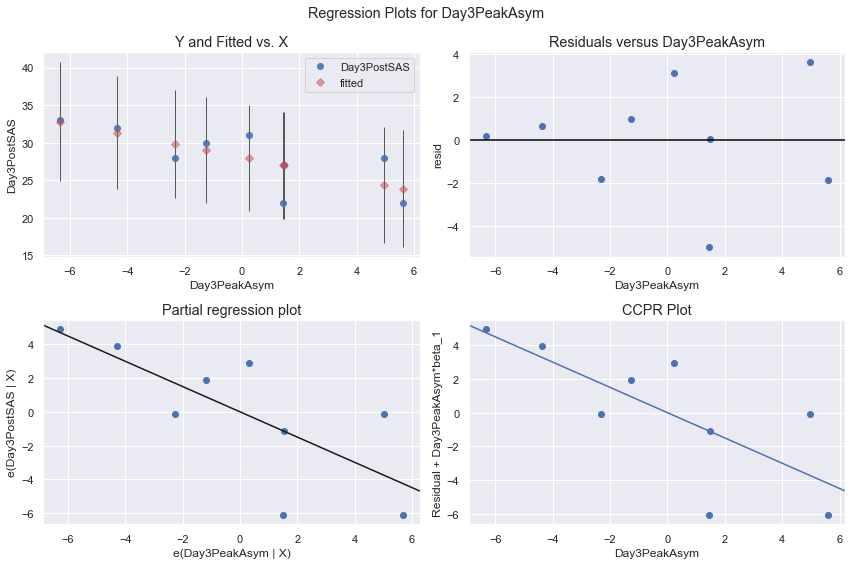

In [42]:
display(reg1.summary())

fig_reg1 = plt.figure(figsize=(12,8))
fig_reg1 = sm.graphics.plot_regress_exog(reg1, 'Day3PeakAsym', fig = fig_reg1)

/Users/jackcrosby/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Day1PreSAS   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2.389
Date:                Sat, 30 Jul 2022   Prob (F-statistic):              0.166
Time:                        15:52:05   Log-Likelihood:                -25.851
No. Observations:                   9   AIC:                             55.70
Df Residuals:                       7   BIC:                             56.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           33.9351      1.731     19.609      0.000      29.843      38.027
Day1PeakAsym_win    -1.0624      0.687     -1.546      0.166      -2.688       0.563
==============================================================================
Omnibus:                        0.458   Durbin-Watson:                   0.674
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.089
Skew:                          -0.192   Prob(JB):                        0.956
Kurtosis:                       2.700   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

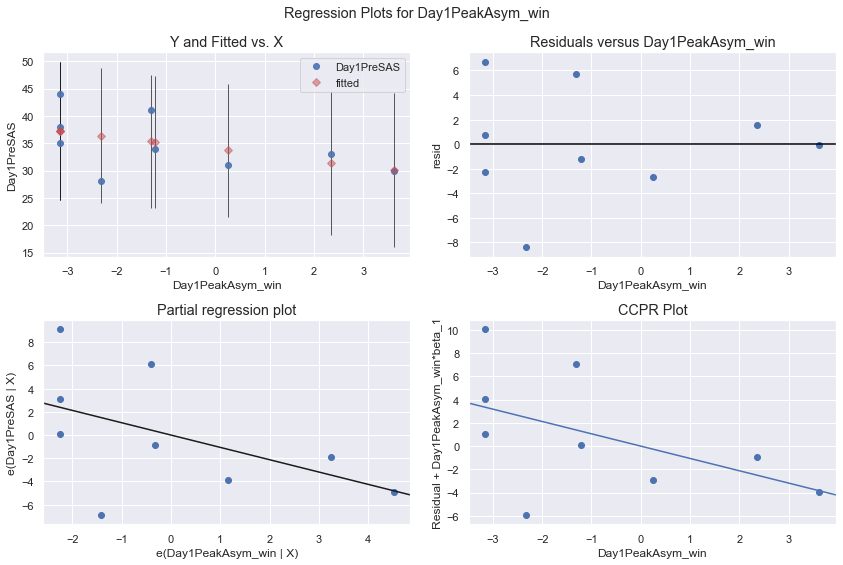

In [43]:
display(reg2.summary())

fig_reg2 = plt.figure(figsize=(12,8))
fig_reg2 = sm.graphics.plot_regress_exog(reg2, 'Day1PeakAsym_win', fig = fig_reg2)

The issue with these regression models is that although levene's test was non-significant for both models, the residual plots show coning suggesting that the data is not homoscedasticstic. Due to how many participants are in the sample, I'd trust the plot over the test. Therefore, the assumption of Homoscedasticity is breached. Observations of Residuals show evidence of coning in both regression models so the p values are likely invalidated. This is further supported by the lack of power and participants

# Graphs

## Bar Graph showing pre & post changes

<Figure size 1800x720 with 0 Axes>

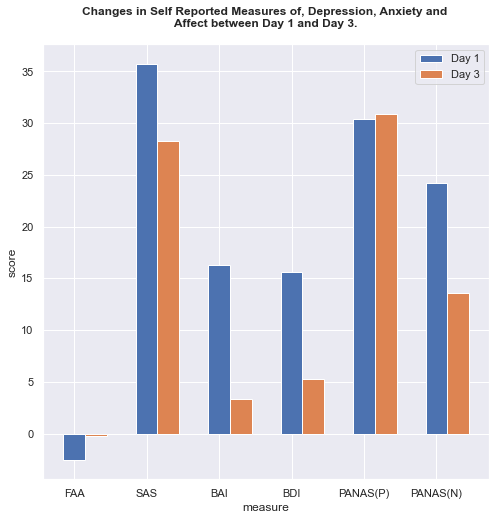

In [44]:
# Bar graph form the data with 8 participants

#Plot graphs
plt.savefig('urmum.jpg')  
plt.rc('font', size=15)
asym = [-0.897778, -0.067778]
SAS = [34.888889, 28.111111]
BAI = [14.777778, 3.000000]
BDI = [14.888889, 5.333333]
PANAS_P = [29.222222, 30.444444]
PANAS_N = [24.000000, 13.777778]

Day1 = [-2.51, 35.7, 16.25, 15.6, 30.37, 24.25]
Day3 = [-0.26, 28.25, 3.37, 5.25, 30.87, 13.62]

x = ['FAA', 'SAS', 'BAI', 'BDI', 'PANAS(P)', 'PANAS(N)']
lgnd = ['Day 1', 'Day 3']
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

width =0.3
plt.bar(x, Day1, width=width)
plt.bar(np.arange(len(Day3)) + width, Day3, width=width)
plt.legend(lgnd,loc=1)
plt.title('Changes in Self Reported Measures of, Depression, Anxiety and \n Affect between Day 1 and Day 3. \n', weight='bold')
plt.xlabel('measure')
plt.ylabel('score')
plt.show() 

## Scatter Plot for FAA and BAI at Day 1 and Day 3

Worth noting, the points on the graph are not even, because 2 of the blue and orange dots have the exact same coordinates.

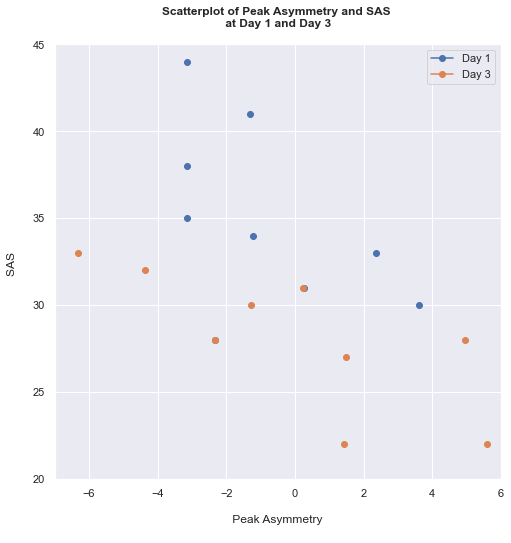

In [45]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.title('Scatterplot of Peak Asymmetry and SAS \n at Day 1 and Day 3 \n', weight='bold')
plt.xlabel('\n Peak Asymmetry \n')
plt.ylabel('SAS \n')
line1, = plt.plot(1, marker='o', label='Day 1')
line2, = plt.plot(1, marker='o', label='Day 3')
plt.legend()
plt.xlim(-7, 6)
plt.ylim(20, 45)
plt.scatter(df4['Day1PeakAsym_win'], df4['Day1PreSAS'])
plt.scatter(df4['Day3PeakAsym'], df4['Day3PostSAS'])

Frontal Alpha Asymmetry (FAA) as a predictor of Anxeity and the efficacy of tACS as a means to reduce this.

The predictive utility of Frontal Alpha Asymmetry on Anxiety and the remedial effect of tACS on anxiety, depression and affect.